# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
#data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

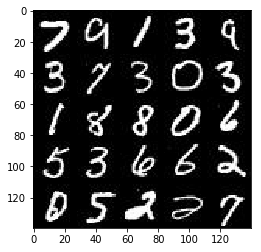

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

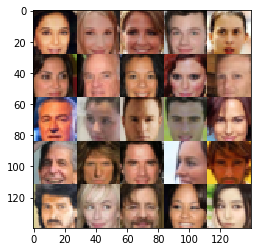

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function

    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels),
                                name='input_real')
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [13]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function

    alpha = 0.12
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same',
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        x1 = tf.maximum(alpha * x1, x1)
        x1 = tf.nn.dropout(x1, 0.7)
        # 14x14x64
        
        x2 = tf.layers.conv2d(x1, 128, 5, strides=1, padding="same",
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(alpha*x2, x2)
        x2 = tf.nn.dropout(x2, 0.7)
        # 14x14x128
        
        x3 = tf.layers.conv2d(x2, 256, 5, strides=2, padding="same",
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(alpha*x3, x3)
        x3 = tf.nn.dropout(x3, 0.7)
        # 7x7x256
        
        x4 = tf.layers.conv2d(x3, 512, 5, strides=1, padding="same",
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        x4 = tf.layers.batch_normalization(x4, training=True)
        x4 = tf.maximum(alpha*x4, x4)
        x4 = tf.nn.dropout(x4, 0.7)
        # 7x7x512
        
        # Flatten
        flat = tf.reshape(x4, (-1, 7*7*512))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        return out, logits



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [14]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    alpha = 0.2
    with tf.variable_scope("generator", reuse=not is_train):
        x1 = tf.layers.dense(z, 7*7*1024)
        x1 = tf.reshape(x1, (-1, 7, 7, 1024))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        x1 = tf.nn.dropout(x1, 0.8)
        # 7x7x1024
        
        x2 = tf.layers.conv2d_transpose(x1, 512, 5, strides=1, padding='same',
                                        kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        x2 = tf.nn.dropout(x2, 0.8)
        # 7x7x512 now
        
        x3 = tf.layers.conv2d_transpose(x2, 256, 5, strides=2, padding='same',
                                        kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        x3 = tf.nn.dropout(x3, 0.8)
        # 14x14x256 now
        
        x4 = tf.layers.conv2d_transpose(x3, 128, 5, strides=1, padding='same',
                                        kernel_initializer=tf.contrib.layers.xavier_initializer())
        x4 = tf.layers.batch_normalization(x4, training=is_train)
        x4 = tf.maximum(alpha * x4, x4)
        x4 = tf.nn.dropout(x4, 0.8)
        # 14x14x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x4, out_channel_dim, 5, strides=2, padding='same')
        # 28x28x3 now
    
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [15]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*0.9))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [16]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope='generator')):
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [17]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [18]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    input_real, input_z, input_lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, input_lr, beta1)
    steps = 0
    
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                # Resize images ( -1 to 1)
                batch_images = batch_images * 2
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, input_lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, input_lr: learning_rate})
                
                if steps % 10 == 0 or steps == 1:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % 100 == 0 or steps == 1:
                    show_generator_output(sess, 20, input_z, data_shape[3], data_image_mode)
        show_generator_output(sess, 20, input_z, data_shape[3], data_image_mode)
        print("Done");
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 21.4988... Generator Loss: 0.0000


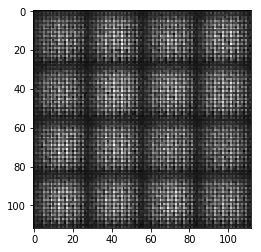

Epoch 1/2... Discriminator Loss: 1.0031... Generator Loss: 6.9645
Epoch 1/2... Discriminator Loss: 0.8076... Generator Loss: 5.5047
Epoch 1/2... Discriminator Loss: 1.5996... Generator Loss: 8.3685
Epoch 1/2... Discriminator Loss: 0.5771... Generator Loss: 4.1318
Epoch 1/2... Discriminator Loss: 3.7544... Generator Loss: 1.7732
Epoch 1/2... Discriminator Loss: 0.6588... Generator Loss: 2.8376
Epoch 1/2... Discriminator Loss: 3.1730... Generator Loss: 6.9220
Epoch 1/2... Discriminator Loss: 2.1470... Generator Loss: 1.3832
Epoch 1/2... Discriminator Loss: 0.7972... Generator Loss: 1.9590
Epoch 1/2... Discriminator Loss: 6.9378... Generator Loss: 9.6617


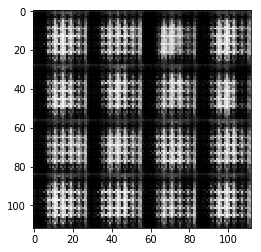

Epoch 1/2... Discriminator Loss: 0.8297... Generator Loss: 1.5236
Epoch 1/2... Discriminator Loss: 1.9055... Generator Loss: 4.4627
Epoch 1/2... Discriminator Loss: 3.7617... Generator Loss: 9.4839
Epoch 1/2... Discriminator Loss: 1.3082... Generator Loss: 0.9424
Epoch 1/2... Discriminator Loss: 3.4341... Generator Loss: 1.6641
Epoch 1/2... Discriminator Loss: 0.6115... Generator Loss: 2.9169
Epoch 1/2... Discriminator Loss: 2.5592... Generator Loss: 2.1736
Epoch 1/2... Discriminator Loss: 1.8110... Generator Loss: 1.2144
Epoch 1/2... Discriminator Loss: 0.8447... Generator Loss: 1.9600
Epoch 1/2... Discriminator Loss: 0.8755... Generator Loss: 2.5057


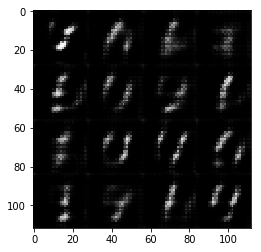

Epoch 1/2... Discriminator Loss: 2.1167... Generator Loss: 0.3529
Epoch 1/2... Discriminator Loss: 0.8240... Generator Loss: 2.2181
Epoch 1/2... Discriminator Loss: 3.7787... Generator Loss: 0.0687
Epoch 1/2... Discriminator Loss: 2.2897... Generator Loss: 2.6027
Epoch 1/2... Discriminator Loss: 1.3254... Generator Loss: 1.3290
Epoch 1/2... Discriminator Loss: 0.9476... Generator Loss: 1.6576
Epoch 1/2... Discriminator Loss: 1.4581... Generator Loss: 3.2375
Epoch 1/2... Discriminator Loss: 1.5454... Generator Loss: 1.8980
Epoch 1/2... Discriminator Loss: 1.3301... Generator Loss: 1.8097
Epoch 1/2... Discriminator Loss: 1.1667... Generator Loss: 1.9813


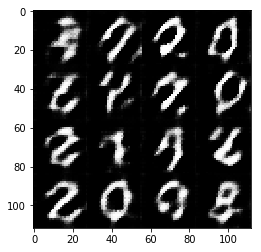

Epoch 1/2... Discriminator Loss: 2.1602... Generator Loss: 0.6519
Epoch 1/2... Discriminator Loss: 1.4332... Generator Loss: 2.0490
Epoch 1/2... Discriminator Loss: 2.3353... Generator Loss: 0.2118
Epoch 1/2... Discriminator Loss: 1.8426... Generator Loss: 1.4810
Epoch 1/2... Discriminator Loss: 1.9829... Generator Loss: 1.4316
Epoch 1/2... Discriminator Loss: 1.8575... Generator Loss: 0.7287
Epoch 1/2... Discriminator Loss: 1.4486... Generator Loss: 1.0320
Epoch 1/2... Discriminator Loss: 1.6334... Generator Loss: 2.4605
Epoch 1/2... Discriminator Loss: 1.2722... Generator Loss: 1.4721
Epoch 1/2... Discriminator Loss: 1.0247... Generator Loss: 1.7625


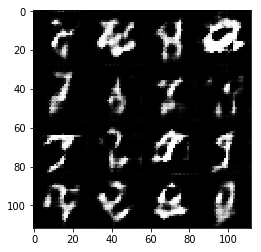

Epoch 1/2... Discriminator Loss: 2.1671... Generator Loss: 0.6510
Epoch 1/2... Discriminator Loss: 1.3285... Generator Loss: 1.0493
Epoch 1/2... Discriminator Loss: 1.9563... Generator Loss: 2.5413
Epoch 1/2... Discriminator Loss: 1.2645... Generator Loss: 0.8520
Epoch 1/2... Discriminator Loss: 0.9559... Generator Loss: 1.3236
Epoch 1/2... Discriminator Loss: 1.5087... Generator Loss: 0.6422
Epoch 1/2... Discriminator Loss: 2.0869... Generator Loss: 0.7118
Epoch 1/2... Discriminator Loss: 1.1274... Generator Loss: 2.7876
Epoch 1/2... Discriminator Loss: 2.2102... Generator Loss: 0.3807
Epoch 1/2... Discriminator Loss: 1.1513... Generator Loss: 2.2612


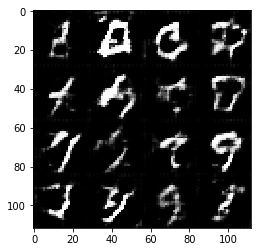

Epoch 1/2... Discriminator Loss: 3.3721... Generator Loss: 0.3277
Epoch 1/2... Discriminator Loss: 1.4459... Generator Loss: 2.0535
Epoch 1/2... Discriminator Loss: 1.4017... Generator Loss: 2.5317
Epoch 1/2... Discriminator Loss: 1.5288... Generator Loss: 0.7991
Epoch 1/2... Discriminator Loss: 2.0383... Generator Loss: 0.8702
Epoch 1/2... Discriminator Loss: 3.0059... Generator Loss: 3.7656
Epoch 1/2... Discriminator Loss: 1.8934... Generator Loss: 2.4927
Epoch 1/2... Discriminator Loss: 1.1257... Generator Loss: 2.1633
Epoch 1/2... Discriminator Loss: 1.6868... Generator Loss: 0.4733
Epoch 1/2... Discriminator Loss: 1.9530... Generator Loss: 0.5763


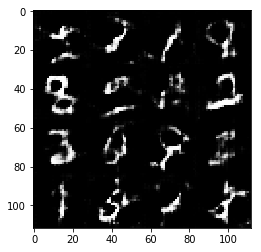

Epoch 1/2... Discriminator Loss: 1.2618... Generator Loss: 1.7204
Epoch 1/2... Discriminator Loss: 1.4775... Generator Loss: 0.7429
Epoch 1/2... Discriminator Loss: 0.9501... Generator Loss: 1.3380
Epoch 1/2... Discriminator Loss: 0.9578... Generator Loss: 0.9187
Epoch 1/2... Discriminator Loss: 2.0792... Generator Loss: 1.3852
Epoch 1/2... Discriminator Loss: 1.3009... Generator Loss: 1.3510
Epoch 1/2... Discriminator Loss: 2.3804... Generator Loss: 0.4926
Epoch 1/2... Discriminator Loss: 1.7924... Generator Loss: 1.7242
Epoch 1/2... Discriminator Loss: 1.6402... Generator Loss: 2.1199
Epoch 1/2... Discriminator Loss: 2.5869... Generator Loss: 0.3023


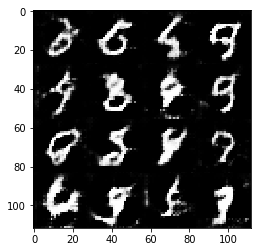

Epoch 1/2... Discriminator Loss: 1.5166... Generator Loss: 0.8052
Epoch 1/2... Discriminator Loss: 1.6814... Generator Loss: 2.0455
Epoch 1/2... Discriminator Loss: 1.9925... Generator Loss: 0.8034
Epoch 1/2... Discriminator Loss: 1.9220... Generator Loss: 0.8145
Epoch 1/2... Discriminator Loss: 1.2201... Generator Loss: 1.1028
Epoch 1/2... Discriminator Loss: 1.4115... Generator Loss: 1.2435
Epoch 1/2... Discriminator Loss: 1.2538... Generator Loss: 1.9734
Epoch 1/2... Discriminator Loss: 1.4428... Generator Loss: 0.7510
Epoch 1/2... Discriminator Loss: 1.5834... Generator Loss: 1.6714
Epoch 1/2... Discriminator Loss: 1.9054... Generator Loss: 2.7645


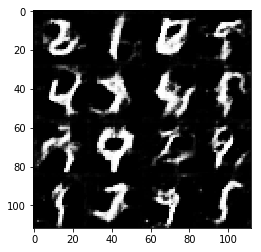

Epoch 1/2... Discriminator Loss: 1.5354... Generator Loss: 1.1639
Epoch 1/2... Discriminator Loss: 2.0087... Generator Loss: 0.4152
Epoch 1/2... Discriminator Loss: 2.0352... Generator Loss: 1.2523
Epoch 1/2... Discriminator Loss: 1.2589... Generator Loss: 1.1878
Epoch 1/2... Discriminator Loss: 1.1611... Generator Loss: 1.5095
Epoch 1/2... Discriminator Loss: 1.4938... Generator Loss: 1.9478
Epoch 1/2... Discriminator Loss: 1.1118... Generator Loss: 0.6827
Epoch 1/2... Discriminator Loss: 2.5314... Generator Loss: 0.4875
Epoch 1/2... Discriminator Loss: 1.4027... Generator Loss: 1.4823
Epoch 1/2... Discriminator Loss: 1.6636... Generator Loss: 0.9168


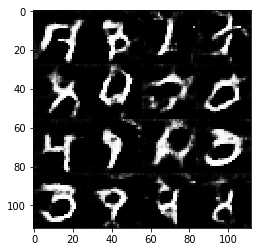

Epoch 1/2... Discriminator Loss: 1.1740... Generator Loss: 1.3915
Epoch 1/2... Discriminator Loss: 1.5540... Generator Loss: 0.4605
Epoch 1/2... Discriminator Loss: 1.0457... Generator Loss: 1.7539
Epoch 1/2... Discriminator Loss: 1.1240... Generator Loss: 1.6271
Epoch 1/2... Discriminator Loss: 1.2003... Generator Loss: 0.9278
Epoch 1/2... Discriminator Loss: 1.2652... Generator Loss: 1.2970
Epoch 1/2... Discriminator Loss: 1.7149... Generator Loss: 1.0401
Epoch 1/2... Discriminator Loss: 1.5124... Generator Loss: 0.8956
Epoch 1/2... Discriminator Loss: 1.4819... Generator Loss: 1.3144
Epoch 1/2... Discriminator Loss: 1.2995... Generator Loss: 1.9198


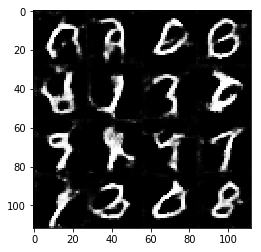

Epoch 1/2... Discriminator Loss: 0.9740... Generator Loss: 1.1199
Epoch 1/2... Discriminator Loss: 1.5173... Generator Loss: 2.2116
Epoch 1/2... Discriminator Loss: 1.0299... Generator Loss: 1.2786
Epoch 1/2... Discriminator Loss: 1.4566... Generator Loss: 1.0079
Epoch 1/2... Discriminator Loss: 1.7454... Generator Loss: 1.6181
Epoch 1/2... Discriminator Loss: 1.6770... Generator Loss: 0.9334
Epoch 1/2... Discriminator Loss: 1.4079... Generator Loss: 1.9295
Epoch 1/2... Discriminator Loss: 1.9265... Generator Loss: 2.7637
Epoch 1/2... Discriminator Loss: 1.0257... Generator Loss: 0.9490
Epoch 1/2... Discriminator Loss: 1.6145... Generator Loss: 0.6081


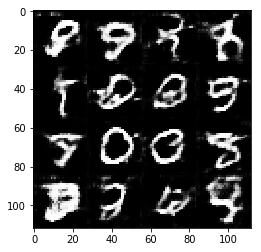

Epoch 1/2... Discriminator Loss: 1.1214... Generator Loss: 1.7755
Epoch 1/2... Discriminator Loss: 1.3905... Generator Loss: 0.9096
Epoch 1/2... Discriminator Loss: 1.4006... Generator Loss: 1.5507
Epoch 1/2... Discriminator Loss: 1.6306... Generator Loss: 1.9304
Epoch 1/2... Discriminator Loss: 0.9433... Generator Loss: 1.7063
Epoch 1/2... Discriminator Loss: 2.7496... Generator Loss: 0.2370
Epoch 1/2... Discriminator Loss: 1.1994... Generator Loss: 0.9859
Epoch 1/2... Discriminator Loss: 1.0818... Generator Loss: 1.4005
Epoch 1/2... Discriminator Loss: 1.1971... Generator Loss: 1.2977
Epoch 1/2... Discriminator Loss: 1.1233... Generator Loss: 1.3270


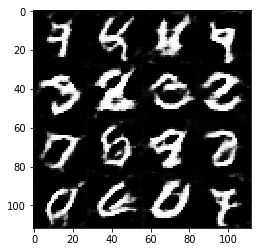

Epoch 1/2... Discriminator Loss: 1.5099... Generator Loss: 1.2528
Epoch 1/2... Discriminator Loss: 1.9201... Generator Loss: 0.9081
Epoch 1/2... Discriminator Loss: 1.7939... Generator Loss: 0.7555
Epoch 1/2... Discriminator Loss: 1.5005... Generator Loss: 0.7096
Epoch 1/2... Discriminator Loss: 1.0484... Generator Loss: 1.2231
Epoch 1/2... Discriminator Loss: 1.9509... Generator Loss: 0.4762
Epoch 1/2... Discriminator Loss: 1.2373... Generator Loss: 1.0609
Epoch 1/2... Discriminator Loss: 1.6683... Generator Loss: 1.5542
Epoch 1/2... Discriminator Loss: 1.4923... Generator Loss: 0.7023
Epoch 1/2... Discriminator Loss: 1.9450... Generator Loss: 0.9887


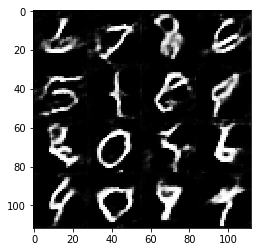

Epoch 1/2... Discriminator Loss: 1.4553... Generator Loss: 1.0404
Epoch 1/2... Discriminator Loss: 1.4590... Generator Loss: 1.1938
Epoch 1/2... Discriminator Loss: 1.0620... Generator Loss: 0.8376
Epoch 1/2... Discriminator Loss: 1.2844... Generator Loss: 1.1421
Epoch 1/2... Discriminator Loss: 1.2044... Generator Loss: 1.0785
Epoch 1/2... Discriminator Loss: 1.7261... Generator Loss: 0.5190
Epoch 1/2... Discriminator Loss: 1.1628... Generator Loss: 0.8786
Epoch 1/2... Discriminator Loss: 1.3419... Generator Loss: 1.2226
Epoch 1/2... Discriminator Loss: 1.3773... Generator Loss: 1.3711
Epoch 1/2... Discriminator Loss: 1.3096... Generator Loss: 1.2204


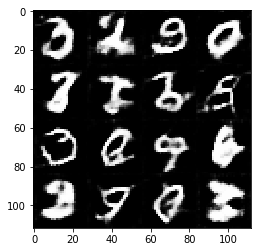

Epoch 1/2... Discriminator Loss: 1.7805... Generator Loss: 0.5462
Epoch 1/2... Discriminator Loss: 1.2965... Generator Loss: 1.6533
Epoch 1/2... Discriminator Loss: 1.1754... Generator Loss: 1.9492
Epoch 1/2... Discriminator Loss: 1.7413... Generator Loss: 0.6683
Epoch 1/2... Discriminator Loss: 1.5563... Generator Loss: 1.3118
Epoch 1/2... Discriminator Loss: 1.4681... Generator Loss: 1.6796
Epoch 1/2... Discriminator Loss: 1.7484... Generator Loss: 0.4782
Epoch 1/2... Discriminator Loss: 1.7110... Generator Loss: 0.3695
Epoch 1/2... Discriminator Loss: 1.5221... Generator Loss: 1.9084
Epoch 1/2... Discriminator Loss: 1.5411... Generator Loss: 0.7490


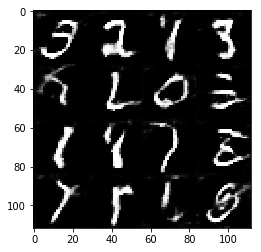

Epoch 1/2... Discriminator Loss: 1.4326... Generator Loss: 0.6944
Epoch 1/2... Discriminator Loss: 1.1767... Generator Loss: 1.1016
Epoch 1/2... Discriminator Loss: 1.4481... Generator Loss: 0.5200
Epoch 1/2... Discriminator Loss: 1.0648... Generator Loss: 1.4589
Epoch 1/2... Discriminator Loss: 1.4698... Generator Loss: 0.7740
Epoch 1/2... Discriminator Loss: 1.2108... Generator Loss: 1.2020
Epoch 1/2... Discriminator Loss: 1.0896... Generator Loss: 0.9344
Epoch 1/2... Discriminator Loss: 1.3177... Generator Loss: 0.6881
Epoch 1/2... Discriminator Loss: 1.3564... Generator Loss: 0.7529
Epoch 1/2... Discriminator Loss: 1.2630... Generator Loss: 1.4231


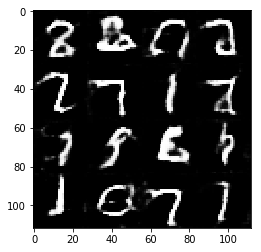

Epoch 1/2... Discriminator Loss: 1.1155... Generator Loss: 1.3851
Epoch 1/2... Discriminator Loss: 1.3700... Generator Loss: 0.6828
Epoch 1/2... Discriminator Loss: 1.1042... Generator Loss: 1.4029
Epoch 1/2... Discriminator Loss: 1.6826... Generator Loss: 1.2245
Epoch 1/2... Discriminator Loss: 1.0356... Generator Loss: 1.3626
Epoch 1/2... Discriminator Loss: 1.5935... Generator Loss: 1.6873
Epoch 1/2... Discriminator Loss: 1.4741... Generator Loss: 1.3454
Epoch 1/2... Discriminator Loss: 1.2927... Generator Loss: 1.4844
Epoch 1/2... Discriminator Loss: 1.0505... Generator Loss: 1.5284
Epoch 1/2... Discriminator Loss: 1.0871... Generator Loss: 1.0937


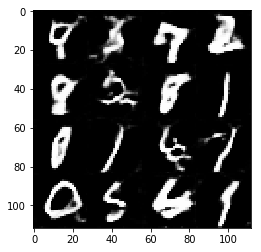

Epoch 1/2... Discriminator Loss: 1.7081... Generator Loss: 0.4524
Epoch 1/2... Discriminator Loss: 1.3591... Generator Loss: 0.8610
Epoch 1/2... Discriminator Loss: 1.0790... Generator Loss: 1.2246
Epoch 1/2... Discriminator Loss: 0.8675... Generator Loss: 1.9923
Epoch 1/2... Discriminator Loss: 1.6797... Generator Loss: 0.3987
Epoch 1/2... Discriminator Loss: 1.1471... Generator Loss: 1.4409
Epoch 1/2... Discriminator Loss: 1.7416... Generator Loss: 0.6516
Epoch 1/2... Discriminator Loss: 1.1862... Generator Loss: 1.8513
Epoch 1/2... Discriminator Loss: 1.2700... Generator Loss: 0.6981
Epoch 1/2... Discriminator Loss: 1.4616... Generator Loss: 0.9378


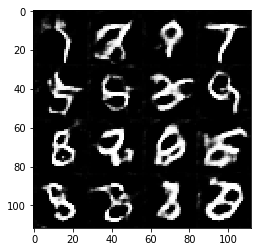

Epoch 1/2... Discriminator Loss: 1.0292... Generator Loss: 1.6100
Epoch 1/2... Discriminator Loss: 1.8821... Generator Loss: 0.4372
Epoch 1/2... Discriminator Loss: 1.2963... Generator Loss: 1.4126
Epoch 1/2... Discriminator Loss: 1.1991... Generator Loss: 0.9920
Epoch 1/2... Discriminator Loss: 1.4768... Generator Loss: 0.8141
Epoch 1/2... Discriminator Loss: 1.2248... Generator Loss: 1.0554
Epoch 1/2... Discriminator Loss: 1.1081... Generator Loss: 1.6805
Epoch 2/2... Discriminator Loss: 0.9855... Generator Loss: 1.8000
Epoch 2/2... Discriminator Loss: 0.8570... Generator Loss: 1.7936
Epoch 2/2... Discriminator Loss: 0.8825... Generator Loss: 1.2343


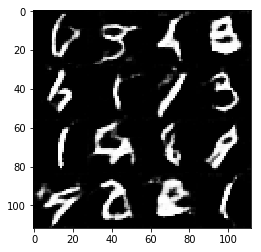

Epoch 2/2... Discriminator Loss: 1.0546... Generator Loss: 1.5260
Epoch 2/2... Discriminator Loss: 1.3203... Generator Loss: 0.7881
Epoch 2/2... Discriminator Loss: 1.2008... Generator Loss: 1.9598
Epoch 2/2... Discriminator Loss: 0.9186... Generator Loss: 0.8222
Epoch 2/2... Discriminator Loss: 0.9628... Generator Loss: 1.3270
Epoch 2/2... Discriminator Loss: 0.9109... Generator Loss: 1.2729
Epoch 2/2... Discriminator Loss: 1.1295... Generator Loss: 2.0057
Epoch 2/2... Discriminator Loss: 1.3250... Generator Loss: 1.8541
Epoch 2/2... Discriminator Loss: 1.2418... Generator Loss: 0.8127
Epoch 2/2... Discriminator Loss: 0.8314... Generator Loss: 1.1932


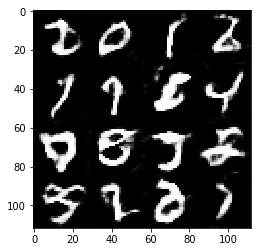

Epoch 2/2... Discriminator Loss: 1.0544... Generator Loss: 1.2734
Epoch 2/2... Discriminator Loss: 1.2543... Generator Loss: 1.5109
Epoch 2/2... Discriminator Loss: 1.1452... Generator Loss: 1.8315
Epoch 2/2... Discriminator Loss: 0.9990... Generator Loss: 1.3564
Epoch 2/2... Discriminator Loss: 1.2192... Generator Loss: 1.0148
Epoch 2/2... Discriminator Loss: 1.5894... Generator Loss: 0.8279
Epoch 2/2... Discriminator Loss: 1.1507... Generator Loss: 1.5130
Epoch 2/2... Discriminator Loss: 1.2240... Generator Loss: 1.4624
Epoch 2/2... Discriminator Loss: 1.1009... Generator Loss: 1.0070
Epoch 2/2... Discriminator Loss: 0.7235... Generator Loss: 1.5743


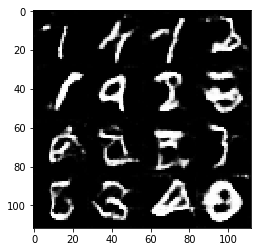

Epoch 2/2... Discriminator Loss: 1.0655... Generator Loss: 1.1750
Epoch 2/2... Discriminator Loss: 1.2425... Generator Loss: 0.6711
Epoch 2/2... Discriminator Loss: 0.8395... Generator Loss: 2.7150
Epoch 2/2... Discriminator Loss: 1.5022... Generator Loss: 1.4701
Epoch 2/2... Discriminator Loss: 0.7750... Generator Loss: 1.7473
Epoch 2/2... Discriminator Loss: 0.9262... Generator Loss: 2.1364
Epoch 2/2... Discriminator Loss: 0.9371... Generator Loss: 1.9004
Epoch 2/2... Discriminator Loss: 1.1383... Generator Loss: 1.7701
Epoch 2/2... Discriminator Loss: 1.7853... Generator Loss: 2.8736
Epoch 2/2... Discriminator Loss: 0.8510... Generator Loss: 1.6788


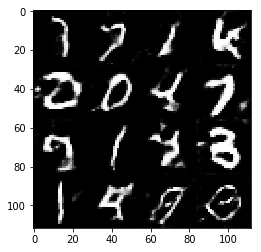

Epoch 2/2... Discriminator Loss: 1.4702... Generator Loss: 1.9194
Epoch 2/2... Discriminator Loss: 1.3183... Generator Loss: 3.2039
Epoch 2/2... Discriminator Loss: 1.6576... Generator Loss: 0.6192
Epoch 2/2... Discriminator Loss: 0.8812... Generator Loss: 2.2528
Epoch 2/2... Discriminator Loss: 1.3275... Generator Loss: 2.9533
Epoch 2/2... Discriminator Loss: 1.3902... Generator Loss: 0.9132
Epoch 2/2... Discriminator Loss: 2.3677... Generator Loss: 0.5833
Epoch 2/2... Discriminator Loss: 1.4652... Generator Loss: 0.6621
Epoch 2/2... Discriminator Loss: 1.2240... Generator Loss: 0.9500
Epoch 2/2... Discriminator Loss: 1.3966... Generator Loss: 0.7906


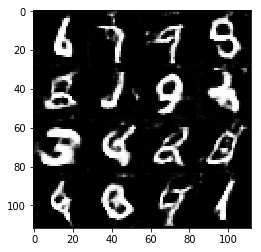

Epoch 2/2... Discriminator Loss: 1.3718... Generator Loss: 1.1340
Epoch 2/2... Discriminator Loss: 1.4081... Generator Loss: 0.6331
Epoch 2/2... Discriminator Loss: 1.5830... Generator Loss: 2.1478
Epoch 2/2... Discriminator Loss: 1.6577... Generator Loss: 0.3817
Epoch 2/2... Discriminator Loss: 1.8554... Generator Loss: 0.4384
Epoch 2/2... Discriminator Loss: 1.1840... Generator Loss: 1.5285
Epoch 2/2... Discriminator Loss: 1.1735... Generator Loss: 2.3707
Epoch 2/2... Discriminator Loss: 0.9542... Generator Loss: 1.7016
Epoch 2/2... Discriminator Loss: 1.5143... Generator Loss: 0.9065
Epoch 2/2... Discriminator Loss: 1.3034... Generator Loss: 1.4779


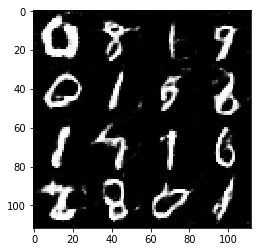

Epoch 2/2... Discriminator Loss: 1.8963... Generator Loss: 3.4951
Epoch 2/2... Discriminator Loss: 1.2201... Generator Loss: 1.7481
Epoch 2/2... Discriminator Loss: 1.4792... Generator Loss: 0.8499
Epoch 2/2... Discriminator Loss: 1.2459... Generator Loss: 1.4506
Epoch 2/2... Discriminator Loss: 1.1070... Generator Loss: 0.9641
Epoch 2/2... Discriminator Loss: 1.5058... Generator Loss: 0.5861
Epoch 2/2... Discriminator Loss: 1.1049... Generator Loss: 1.4615
Epoch 2/2... Discriminator Loss: 1.0762... Generator Loss: 1.4973
Epoch 2/2... Discriminator Loss: 0.9768... Generator Loss: 1.1765
Epoch 2/2... Discriminator Loss: 1.1907... Generator Loss: 0.7222


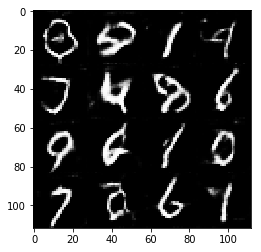

Epoch 2/2... Discriminator Loss: 1.2600... Generator Loss: 1.1448
Epoch 2/2... Discriminator Loss: 0.8454... Generator Loss: 1.5464
Epoch 2/2... Discriminator Loss: 1.0328... Generator Loss: 1.1458
Epoch 2/2... Discriminator Loss: 1.3475... Generator Loss: 2.0093
Epoch 2/2... Discriminator Loss: 1.1904... Generator Loss: 1.3107
Epoch 2/2... Discriminator Loss: 1.5693... Generator Loss: 0.5757
Epoch 2/2... Discriminator Loss: 1.1966... Generator Loss: 1.4861
Epoch 2/2... Discriminator Loss: 1.2001... Generator Loss: 1.4333
Epoch 2/2... Discriminator Loss: 1.0482... Generator Loss: 0.9170
Epoch 2/2... Discriminator Loss: 1.0819... Generator Loss: 1.4605


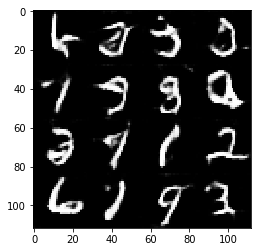

Epoch 2/2... Discriminator Loss: 1.3658... Generator Loss: 1.9925
Epoch 2/2... Discriminator Loss: 1.2284... Generator Loss: 2.7464
Epoch 2/2... Discriminator Loss: 0.8378... Generator Loss: 1.5259
Epoch 2/2... Discriminator Loss: 0.7475... Generator Loss: 1.7800
Epoch 2/2... Discriminator Loss: 1.2659... Generator Loss: 2.3383
Epoch 2/2... Discriminator Loss: 1.1109... Generator Loss: 1.0440
Epoch 2/2... Discriminator Loss: 1.8377... Generator Loss: 1.4178
Epoch 2/2... Discriminator Loss: 0.7839... Generator Loss: 1.2683
Epoch 2/2... Discriminator Loss: 1.4587... Generator Loss: 0.7434
Epoch 2/2... Discriminator Loss: 0.7851... Generator Loss: 1.4592


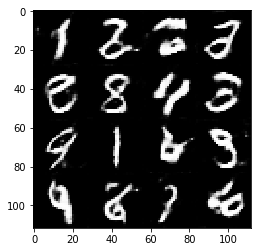

Epoch 2/2... Discriminator Loss: 1.4334... Generator Loss: 0.6041
Epoch 2/2... Discriminator Loss: 1.3642... Generator Loss: 0.7860
Epoch 2/2... Discriminator Loss: 0.9738... Generator Loss: 1.2437
Epoch 2/2... Discriminator Loss: 0.9259... Generator Loss: 2.0187
Epoch 2/2... Discriminator Loss: 1.0412... Generator Loss: 2.0980
Epoch 2/2... Discriminator Loss: 0.7658... Generator Loss: 2.4243
Epoch 2/2... Discriminator Loss: 1.0376... Generator Loss: 1.4530
Epoch 2/2... Discriminator Loss: 1.0127... Generator Loss: 0.9122
Epoch 2/2... Discriminator Loss: 0.9010... Generator Loss: 1.3736
Epoch 2/2... Discriminator Loss: 0.8756... Generator Loss: 1.6121


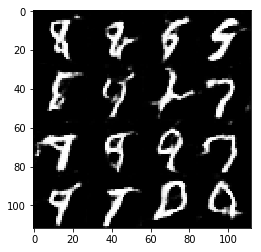

Epoch 2/2... Discriminator Loss: 2.7896... Generator Loss: 5.7036
Epoch 2/2... Discriminator Loss: 0.5667... Generator Loss: 2.8686
Epoch 2/2... Discriminator Loss: 0.9190... Generator Loss: 1.5316
Epoch 2/2... Discriminator Loss: 0.9822... Generator Loss: 3.7583
Epoch 2/2... Discriminator Loss: 1.0758... Generator Loss: 2.4889
Epoch 2/2... Discriminator Loss: 1.2277... Generator Loss: 1.2861
Epoch 2/2... Discriminator Loss: 1.1071... Generator Loss: 1.2113
Epoch 2/2... Discriminator Loss: 0.8800... Generator Loss: 0.8785
Epoch 2/2... Discriminator Loss: 1.1077... Generator Loss: 1.4797
Epoch 2/2... Discriminator Loss: 1.1522... Generator Loss: 1.5023


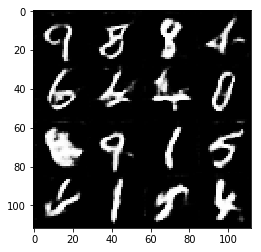

Epoch 2/2... Discriminator Loss: 1.6284... Generator Loss: 2.7766
Epoch 2/2... Discriminator Loss: 0.6418... Generator Loss: 1.7946
Epoch 2/2... Discriminator Loss: 0.9674... Generator Loss: 1.8964
Epoch 2/2... Discriminator Loss: 0.6671... Generator Loss: 2.4378
Epoch 2/2... Discriminator Loss: 1.2762... Generator Loss: 1.1616
Epoch 2/2... Discriminator Loss: 0.9623... Generator Loss: 1.7142
Epoch 2/2... Discriminator Loss: 0.7129... Generator Loss: 2.5586
Epoch 2/2... Discriminator Loss: 1.4544... Generator Loss: 0.7179
Epoch 2/2... Discriminator Loss: 0.9824... Generator Loss: 1.8005
Epoch 2/2... Discriminator Loss: 1.0198... Generator Loss: 1.3350


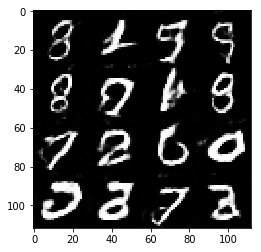

Epoch 2/2... Discriminator Loss: 0.9006... Generator Loss: 1.4570
Epoch 2/2... Discriminator Loss: 1.1272... Generator Loss: 3.4444
Epoch 2/2... Discriminator Loss: 0.8889... Generator Loss: 2.2442
Epoch 2/2... Discriminator Loss: 1.4826... Generator Loss: 1.6570
Epoch 2/2... Discriminator Loss: 0.8717... Generator Loss: 1.9694
Epoch 2/2... Discriminator Loss: 0.7648... Generator Loss: 1.7763
Epoch 2/2... Discriminator Loss: 1.2066... Generator Loss: 0.9151
Epoch 2/2... Discriminator Loss: 1.0317... Generator Loss: 0.9133
Epoch 2/2... Discriminator Loss: 0.8713... Generator Loss: 2.7344
Epoch 2/2... Discriminator Loss: 0.8783... Generator Loss: 2.1735


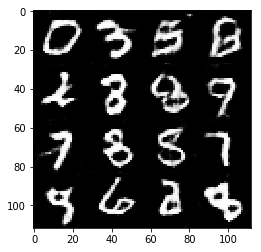

Epoch 2/2... Discriminator Loss: 1.0610... Generator Loss: 2.7754
Epoch 2/2... Discriminator Loss: 0.8346... Generator Loss: 1.2297
Epoch 2/2... Discriminator Loss: 1.5162... Generator Loss: 1.3824
Epoch 2/2... Discriminator Loss: 0.8725... Generator Loss: 1.4844
Epoch 2/2... Discriminator Loss: 0.8216... Generator Loss: 1.7688
Epoch 2/2... Discriminator Loss: 1.0886... Generator Loss: 1.3903
Epoch 2/2... Discriminator Loss: 1.1359... Generator Loss: 3.8110
Epoch 2/2... Discriminator Loss: 0.6376... Generator Loss: 2.0928
Epoch 2/2... Discriminator Loss: 1.6935... Generator Loss: 0.7049
Epoch 2/2... Discriminator Loss: 1.2431... Generator Loss: 1.5055


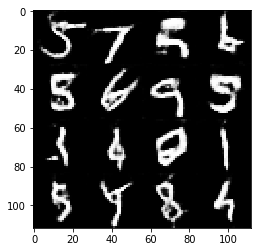

Epoch 2/2... Discriminator Loss: 1.2878... Generator Loss: 1.8595
Epoch 2/2... Discriminator Loss: 1.3143... Generator Loss: 1.2435
Epoch 2/2... Discriminator Loss: 0.8360... Generator Loss: 1.5771
Epoch 2/2... Discriminator Loss: 0.7897... Generator Loss: 1.5396
Epoch 2/2... Discriminator Loss: 0.8885... Generator Loss: 1.3666
Epoch 2/2... Discriminator Loss: 0.7446... Generator Loss: 2.4944
Epoch 2/2... Discriminator Loss: 0.8361... Generator Loss: 1.3102
Epoch 2/2... Discriminator Loss: 1.1701... Generator Loss: 3.6957
Epoch 2/2... Discriminator Loss: 0.7957... Generator Loss: 1.9222
Epoch 2/2... Discriminator Loss: 1.1017... Generator Loss: 1.0454


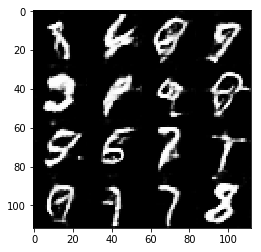

Epoch 2/2... Discriminator Loss: 2.2238... Generator Loss: 0.4510
Epoch 2/2... Discriminator Loss: 1.2905... Generator Loss: 3.3410
Epoch 2/2... Discriminator Loss: 0.8798... Generator Loss: 1.7872
Epoch 2/2... Discriminator Loss: 0.9695... Generator Loss: 0.9273
Epoch 2/2... Discriminator Loss: 0.7123... Generator Loss: 2.0193
Epoch 2/2... Discriminator Loss: 1.3275... Generator Loss: 3.2292
Epoch 2/2... Discriminator Loss: 1.4835... Generator Loss: 0.6012
Epoch 2/2... Discriminator Loss: 1.2003... Generator Loss: 1.2704
Epoch 2/2... Discriminator Loss: 0.6980... Generator Loss: 1.5179
Epoch 2/2... Discriminator Loss: 1.0965... Generator Loss: 0.9316


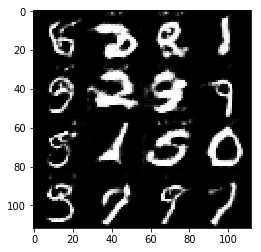

Epoch 2/2... Discriminator Loss: 1.6288... Generator Loss: 3.5204
Epoch 2/2... Discriminator Loss: 0.8472... Generator Loss: 2.2286
Epoch 2/2... Discriminator Loss: 0.7775... Generator Loss: 2.2413
Epoch 2/2... Discriminator Loss: 1.0806... Generator Loss: 1.4216
Epoch 2/2... Discriminator Loss: 0.8984... Generator Loss: 1.2936
Epoch 2/2... Discriminator Loss: 1.4693... Generator Loss: 0.9635
Epoch 2/2... Discriminator Loss: 0.8396... Generator Loss: 1.8431
Epoch 2/2... Discriminator Loss: 1.5934... Generator Loss: 0.5955
Epoch 2/2... Discriminator Loss: 0.6096... Generator Loss: 2.3254
Epoch 2/2... Discriminator Loss: 0.9511... Generator Loss: 1.2668


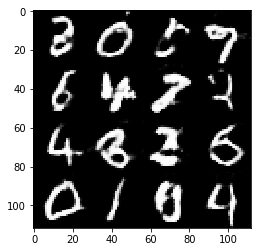

Epoch 2/2... Discriminator Loss: 1.1145... Generator Loss: 2.0487
Epoch 2/2... Discriminator Loss: 0.6920... Generator Loss: 1.5560
Epoch 2/2... Discriminator Loss: 1.0706... Generator Loss: 0.7178
Epoch 2/2... Discriminator Loss: 0.9290... Generator Loss: 1.5997
Epoch 2/2... Discriminator Loss: 0.9741... Generator Loss: 1.0452
Epoch 2/2... Discriminator Loss: 0.7154... Generator Loss: 2.6423
Epoch 2/2... Discriminator Loss: 1.5832... Generator Loss: 1.1239
Epoch 2/2... Discriminator Loss: 0.9225... Generator Loss: 1.2802
Epoch 2/2... Discriminator Loss: 0.8612... Generator Loss: 1.7782
Epoch 2/2... Discriminator Loss: 1.1511... Generator Loss: 1.7073


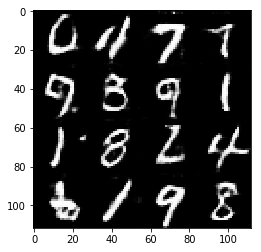

Epoch 2/2... Discriminator Loss: 0.7585... Generator Loss: 1.6716
Epoch 2/2... Discriminator Loss: 1.2423... Generator Loss: 1.5815
Epoch 2/2... Discriminator Loss: 0.8083... Generator Loss: 2.4110
Epoch 2/2... Discriminator Loss: 0.7044... Generator Loss: 1.7310
Epoch 2/2... Discriminator Loss: 0.5472... Generator Loss: 1.8089
Epoch 2/2... Discriminator Loss: 0.9757... Generator Loss: 1.8765
Epoch 2/2... Discriminator Loss: 2.0670... Generator Loss: 0.8914
Epoch 2/2... Discriminator Loss: 1.0348... Generator Loss: 1.8081
Epoch 2/2... Discriminator Loss: 0.7420... Generator Loss: 1.5037
Epoch 2/2... Discriminator Loss: 0.8787... Generator Loss: 3.4604


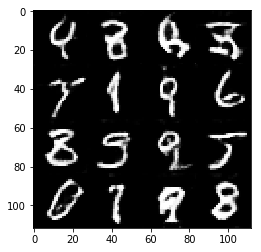

Epoch 2/2... Discriminator Loss: 0.8520... Generator Loss: 1.5689
Epoch 2/2... Discriminator Loss: 1.5175... Generator Loss: 0.8299
Epoch 2/2... Discriminator Loss: 0.8824... Generator Loss: 2.0709
Epoch 2/2... Discriminator Loss: 0.7047... Generator Loss: 1.8059
Epoch 2/2... Discriminator Loss: 0.7489... Generator Loss: 1.6373


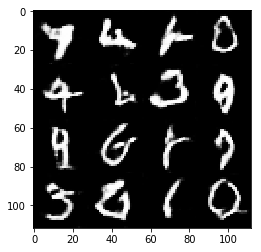

Done


In [ ]:
batch_size = 64
z_dim = 100
learning_rate = 0.0008
beta1 = 0.4


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 7.8542... Generator Loss: 0.0028


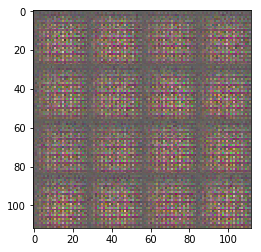

Epoch 1/1... Discriminator Loss: 3.3673... Generator Loss: 8.6377
Epoch 1/1... Discriminator Loss: 4.7236... Generator Loss: 12.6809
Epoch 1/1... Discriminator Loss: 1.7323... Generator Loss: 0.8112
Epoch 1/1... Discriminator Loss: 1.4245... Generator Loss: 2.6124
Epoch 1/1... Discriminator Loss: 1.6130... Generator Loss: 3.0580
Epoch 1/1... Discriminator Loss: 2.3331... Generator Loss: 0.3592
Epoch 1/1... Discriminator Loss: 1.7905... Generator Loss: 0.7657
Epoch 1/1... Discriminator Loss: 1.2880... Generator Loss: 2.0250
Epoch 1/1... Discriminator Loss: 1.1361... Generator Loss: 1.5664
Epoch 1/1... Discriminator Loss: 1.3414... Generator Loss: 0.6774


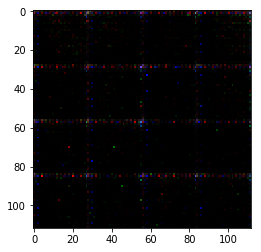

Epoch 1/1... Discriminator Loss: 1.2473... Generator Loss: 1.4896
Epoch 1/1... Discriminator Loss: 1.1630... Generator Loss: 1.0353
Epoch 1/1... Discriminator Loss: 0.9740... Generator Loss: 1.3788
Epoch 1/1... Discriminator Loss: 1.0501... Generator Loss: 1.0150
Epoch 1/1... Discriminator Loss: 0.9905... Generator Loss: 1.7813
Epoch 1/1... Discriminator Loss: 1.1816... Generator Loss: 1.1083
Epoch 1/1... Discriminator Loss: 1.2913... Generator Loss: 0.7126
Epoch 1/1... Discriminator Loss: 1.0034... Generator Loss: 2.2374
Epoch 1/1... Discriminator Loss: 1.4318... Generator Loss: 2.1908
Epoch 1/1... Discriminator Loss: 1.0956... Generator Loss: 0.6947


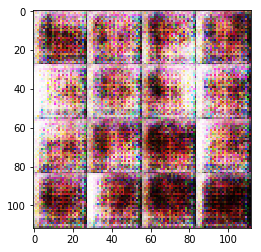

Epoch 1/1... Discriminator Loss: 0.6512... Generator Loss: 1.8697
Epoch 1/1... Discriminator Loss: 0.9112... Generator Loss: 1.3937
Epoch 1/1... Discriminator Loss: 0.8612... Generator Loss: 1.3222
Epoch 1/1... Discriminator Loss: 2.1237... Generator Loss: 2.7837
Epoch 1/1... Discriminator Loss: 0.9477... Generator Loss: 1.5849
Epoch 1/1... Discriminator Loss: 1.2298... Generator Loss: 1.6243
Epoch 1/1... Discriminator Loss: 1.7982... Generator Loss: 1.6576
Epoch 1/1... Discriminator Loss: 1.1496... Generator Loss: 1.4544
Epoch 1/1... Discriminator Loss: 0.9859... Generator Loss: 1.1376
Epoch 1/1... Discriminator Loss: 3.8587... Generator Loss: 4.4178


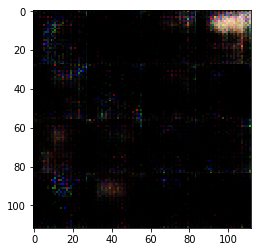

Epoch 1/1... Discriminator Loss: 1.1735... Generator Loss: 1.0494
Epoch 1/1... Discriminator Loss: 1.4387... Generator Loss: 1.2467
Epoch 1/1... Discriminator Loss: 1.9194... Generator Loss: 0.4124
Epoch 1/1... Discriminator Loss: 1.2903... Generator Loss: 1.0881
Epoch 1/1... Discriminator Loss: 1.3680... Generator Loss: 0.9005
Epoch 1/1... Discriminator Loss: 1.1864... Generator Loss: 0.9288
Epoch 1/1... Discriminator Loss: 2.1362... Generator Loss: 0.2776
Epoch 1/1... Discriminator Loss: 1.0516... Generator Loss: 1.3714
Epoch 1/1... Discriminator Loss: 2.4621... Generator Loss: 4.4660
Epoch 1/1... Discriminator Loss: 0.9939... Generator Loss: 1.1032


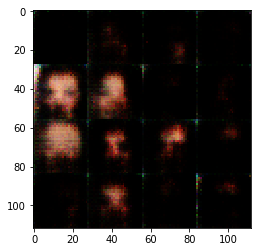

Epoch 1/1... Discriminator Loss: 1.6791... Generator Loss: 0.5554
Epoch 1/1... Discriminator Loss: 1.4009... Generator Loss: 0.9022
Epoch 1/1... Discriminator Loss: 1.4525... Generator Loss: 1.9093
Epoch 1/1... Discriminator Loss: 1.8623... Generator Loss: 2.2899
Epoch 1/1... Discriminator Loss: 1.0011... Generator Loss: 1.7768
Epoch 1/1... Discriminator Loss: 1.0514... Generator Loss: 1.7834
Epoch 1/1... Discriminator Loss: 1.0988... Generator Loss: 0.8938
Epoch 1/1... Discriminator Loss: 1.8803... Generator Loss: 0.4980
Epoch 1/1... Discriminator Loss: 2.5024... Generator Loss: 0.2622
Epoch 1/1... Discriminator Loss: 1.0513... Generator Loss: 1.3446


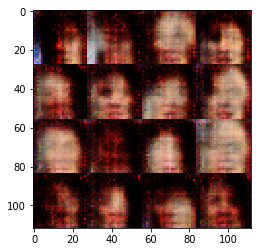

Epoch 1/1... Discriminator Loss: 1.9402... Generator Loss: 1.8706
Epoch 1/1... Discriminator Loss: 1.0611... Generator Loss: 2.1009
Epoch 1/1... Discriminator Loss: 2.8883... Generator Loss: 3.7625
Epoch 1/1... Discriminator Loss: 0.6324... Generator Loss: 2.2476
Epoch 1/1... Discriminator Loss: 1.2362... Generator Loss: 0.7917
Epoch 1/1... Discriminator Loss: 1.1045... Generator Loss: 0.8386
Epoch 1/1... Discriminator Loss: 0.9213... Generator Loss: 0.9241
Epoch 1/1... Discriminator Loss: 1.3938... Generator Loss: 0.8835
Epoch 1/1... Discriminator Loss: 1.3986... Generator Loss: 2.2557
Epoch 1/1... Discriminator Loss: 1.0894... Generator Loss: 1.0925


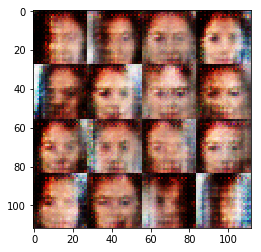

Epoch 1/1... Discriminator Loss: 2.6350... Generator Loss: 0.2157
Epoch 1/1... Discriminator Loss: 1.4380... Generator Loss: 0.8346
Epoch 1/1... Discriminator Loss: 1.4955... Generator Loss: 1.1441
Epoch 1/1... Discriminator Loss: 1.0054... Generator Loss: 1.2409
Epoch 1/1... Discriminator Loss: 0.8778... Generator Loss: 1.5812
Epoch 1/1... Discriminator Loss: 1.5341... Generator Loss: 0.8884
Epoch 1/1... Discriminator Loss: 1.3700... Generator Loss: 1.8094
Epoch 1/1... Discriminator Loss: 1.2389... Generator Loss: 1.4517
Epoch 1/1... Discriminator Loss: 1.7417... Generator Loss: 0.3438
Epoch 1/1... Discriminator Loss: 1.7785... Generator Loss: 1.8179


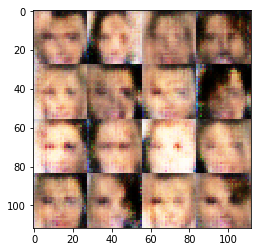

Epoch 1/1... Discriminator Loss: 1.1071... Generator Loss: 0.8215
Epoch 1/1... Discriminator Loss: 1.6171... Generator Loss: 0.5517
Epoch 1/1... Discriminator Loss: 2.4048... Generator Loss: 0.2160
Epoch 1/1... Discriminator Loss: 1.3308... Generator Loss: 1.0274
Epoch 1/1... Discriminator Loss: 1.5320... Generator Loss: 0.7130
Epoch 1/1... Discriminator Loss: 1.2411... Generator Loss: 1.0882
Epoch 1/1... Discriminator Loss: 1.1557... Generator Loss: 1.9910
Epoch 1/1... Discriminator Loss: 1.5184... Generator Loss: 0.8721
Epoch 1/1... Discriminator Loss: 1.0349... Generator Loss: 0.9055
Epoch 1/1... Discriminator Loss: 1.4100... Generator Loss: 1.1951


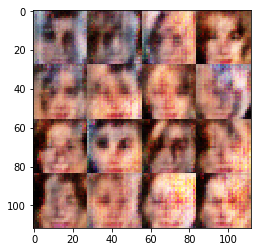

Epoch 1/1... Discriminator Loss: 0.7641... Generator Loss: 1.1101
Epoch 1/1... Discriminator Loss: 1.4913... Generator Loss: 0.4748
Epoch 1/1... Discriminator Loss: 1.6795... Generator Loss: 0.8866
Epoch 1/1... Discriminator Loss: 1.7703... Generator Loss: 0.6473
Epoch 1/1... Discriminator Loss: 1.4773... Generator Loss: 0.8665
Epoch 1/1... Discriminator Loss: 1.4074... Generator Loss: 0.9581
Epoch 1/1... Discriminator Loss: 1.5132... Generator Loss: 1.1853
Epoch 1/1... Discriminator Loss: 1.4052... Generator Loss: 0.8735
Epoch 1/1... Discriminator Loss: 1.3340... Generator Loss: 1.1707
Epoch 1/1... Discriminator Loss: 1.3990... Generator Loss: 1.4472


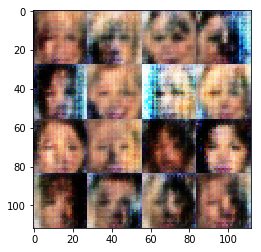

Epoch 1/1... Discriminator Loss: 1.4754... Generator Loss: 0.9762
Epoch 1/1... Discriminator Loss: 1.2510... Generator Loss: 0.7266
Epoch 1/1... Discriminator Loss: 1.6075... Generator Loss: 0.8260
Epoch 1/1... Discriminator Loss: 1.2624... Generator Loss: 0.8920
Epoch 1/1... Discriminator Loss: 1.1808... Generator Loss: 0.9738
Epoch 1/1... Discriminator Loss: 1.2766... Generator Loss: 1.0691
Epoch 1/1... Discriminator Loss: 1.7228... Generator Loss: 0.5496
Epoch 1/1... Discriminator Loss: 1.4774... Generator Loss: 0.8241
Epoch 1/1... Discriminator Loss: 1.3575... Generator Loss: 1.0132
Epoch 1/1... Discriminator Loss: 1.2258... Generator Loss: 1.0503


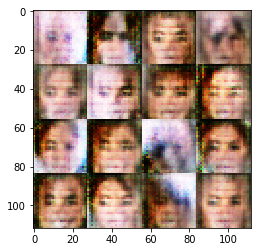

Epoch 1/1... Discriminator Loss: 1.1218... Generator Loss: 1.6312
Epoch 1/1... Discriminator Loss: 1.3624... Generator Loss: 1.6893
Epoch 1/1... Discriminator Loss: 1.3082... Generator Loss: 1.1358
Epoch 1/1... Discriminator Loss: 1.1967... Generator Loss: 0.6226
Epoch 1/1... Discriminator Loss: 1.6014... Generator Loss: 2.0534
Epoch 1/1... Discriminator Loss: 1.4619... Generator Loss: 0.9772
Epoch 1/1... Discriminator Loss: 1.0024... Generator Loss: 1.1836
Epoch 1/1... Discriminator Loss: 1.4838... Generator Loss: 1.7368
Epoch 1/1... Discriminator Loss: 1.8835... Generator Loss: 0.4216
Epoch 1/1... Discriminator Loss: 1.9019... Generator Loss: 1.6526


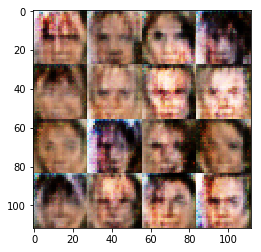

Epoch 1/1... Discriminator Loss: 1.1102... Generator Loss: 1.0928
Epoch 1/1... Discriminator Loss: 1.0046... Generator Loss: 0.8080
Epoch 1/1... Discriminator Loss: 1.4332... Generator Loss: 0.7614
Epoch 1/1... Discriminator Loss: 1.5443... Generator Loss: 0.5453
Epoch 1/1... Discriminator Loss: 0.8891... Generator Loss: 1.3410
Epoch 1/1... Discriminator Loss: 1.0141... Generator Loss: 1.4763
Epoch 1/1... Discriminator Loss: 0.9996... Generator Loss: 0.9174
Epoch 1/1... Discriminator Loss: 3.8950... Generator Loss: 5.5993
Epoch 1/1... Discriminator Loss: 1.3052... Generator Loss: 0.7270
Epoch 1/1... Discriminator Loss: 2.0342... Generator Loss: 3.0513


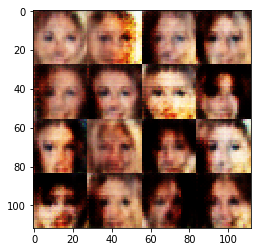

Epoch 1/1... Discriminator Loss: 0.9718... Generator Loss: 1.1036
Epoch 1/1... Discriminator Loss: 1.2269... Generator Loss: 0.9154
Epoch 1/1... Discriminator Loss: 0.5295... Generator Loss: 2.3845
Epoch 1/1... Discriminator Loss: 1.0893... Generator Loss: 0.8494
Epoch 1/1... Discriminator Loss: 1.0559... Generator Loss: 0.7774
Epoch 1/1... Discriminator Loss: 0.8651... Generator Loss: 1.4027
Epoch 1/1... Discriminator Loss: 0.9476... Generator Loss: 1.8546
Epoch 1/1... Discriminator Loss: 1.1340... Generator Loss: 0.8208
Epoch 1/1... Discriminator Loss: 1.0618... Generator Loss: 0.7650
Epoch 1/1... Discriminator Loss: 0.8116... Generator Loss: 1.3258


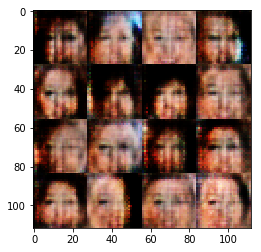

Epoch 1/1... Discriminator Loss: 1.3256... Generator Loss: 0.7369
Epoch 1/1... Discriminator Loss: 1.3224... Generator Loss: 1.1318
Epoch 1/1... Discriminator Loss: 1.3102... Generator Loss: 0.7151
Epoch 1/1... Discriminator Loss: 1.1425... Generator Loss: 0.6822
Epoch 1/1... Discriminator Loss: 1.4835... Generator Loss: 0.7558
Epoch 1/1... Discriminator Loss: 1.2838... Generator Loss: 0.9729
Epoch 1/1... Discriminator Loss: 1.1118... Generator Loss: 2.1135
Epoch 1/1... Discriminator Loss: 0.9381... Generator Loss: 0.8556
Epoch 1/1... Discriminator Loss: 1.0808... Generator Loss: 1.1570
Epoch 1/1... Discriminator Loss: 0.8257... Generator Loss: 1.5549


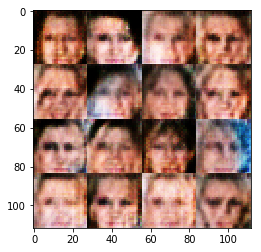

Epoch 1/1... Discriminator Loss: 1.1535... Generator Loss: 0.8359
Epoch 1/1... Discriminator Loss: 1.5039... Generator Loss: 1.1994
Epoch 1/1... Discriminator Loss: 1.2314... Generator Loss: 0.8897
Epoch 1/1... Discriminator Loss: 1.0365... Generator Loss: 1.3466
Epoch 1/1... Discriminator Loss: 1.5401... Generator Loss: 0.5507
Epoch 1/1... Discriminator Loss: 1.4887... Generator Loss: 0.6324
Epoch 1/1... Discriminator Loss: 1.2824... Generator Loss: 1.2119
Epoch 1/1... Discriminator Loss: 1.2878... Generator Loss: 1.3390
Epoch 1/1... Discriminator Loss: 1.3445... Generator Loss: 2.0717
Epoch 1/1... Discriminator Loss: 1.1300... Generator Loss: 1.2286


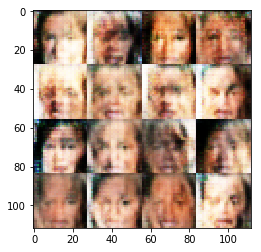

Epoch 1/1... Discriminator Loss: 1.4515... Generator Loss: 0.5285
Epoch 1/1... Discriminator Loss: 1.2983... Generator Loss: 0.7720
Epoch 1/1... Discriminator Loss: 1.0089... Generator Loss: 0.9937
Epoch 1/1... Discriminator Loss: 1.3980... Generator Loss: 0.8630
Epoch 1/1... Discriminator Loss: 1.0160... Generator Loss: 1.0715
Epoch 1/1... Discriminator Loss: 1.2143... Generator Loss: 1.0311
Epoch 1/1... Discriminator Loss: 1.9600... Generator Loss: 0.3620
Epoch 1/1... Discriminator Loss: 1.4290... Generator Loss: 0.6085
Epoch 1/1... Discriminator Loss: 1.0460... Generator Loss: 1.2981
Epoch 1/1... Discriminator Loss: 1.9168... Generator Loss: 0.3502


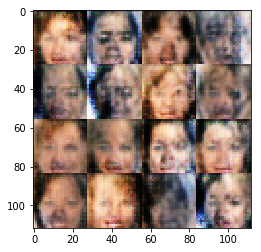

Epoch 1/1... Discriminator Loss: 1.1532... Generator Loss: 1.3330
Epoch 1/1... Discriminator Loss: 1.2497... Generator Loss: 1.2055
Epoch 1/1... Discriminator Loss: 1.2891... Generator Loss: 0.6651
Epoch 1/1... Discriminator Loss: 0.8343... Generator Loss: 1.1517
Epoch 1/1... Discriminator Loss: 1.3197... Generator Loss: 1.0258
Epoch 1/1... Discriminator Loss: 1.8982... Generator Loss: 3.6024
Epoch 1/1... Discriminator Loss: 1.2551... Generator Loss: 0.5056
Epoch 1/1... Discriminator Loss: 1.1661... Generator Loss: 0.9662
Epoch 1/1... Discriminator Loss: 1.6910... Generator Loss: 0.3250
Epoch 1/1... Discriminator Loss: 1.0115... Generator Loss: 1.5525


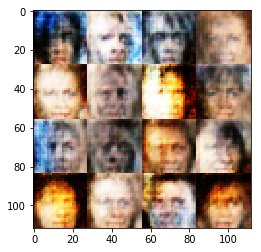

Epoch 1/1... Discriminator Loss: 1.8301... Generator Loss: 1.3942
Epoch 1/1... Discriminator Loss: 1.1970... Generator Loss: 1.0615
Epoch 1/1... Discriminator Loss: 1.0269... Generator Loss: 1.2278
Epoch 1/1... Discriminator Loss: 1.3785... Generator Loss: 1.1161
Epoch 1/1... Discriminator Loss: 1.3649... Generator Loss: 1.0417
Epoch 1/1... Discriminator Loss: 1.4744... Generator Loss: 1.0229
Epoch 1/1... Discriminator Loss: 1.4177... Generator Loss: 1.2152
Epoch 1/1... Discriminator Loss: 1.2533... Generator Loss: 0.7451
Epoch 1/1... Discriminator Loss: 1.3343... Generator Loss: 1.1594
Epoch 1/1... Discriminator Loss: 1.3603... Generator Loss: 0.9885


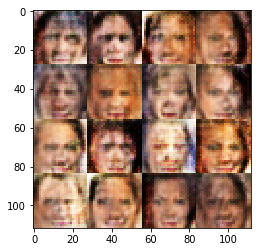

Epoch 1/1... Discriminator Loss: 1.0240... Generator Loss: 0.9865
Epoch 1/1... Discriminator Loss: 1.5662... Generator Loss: 2.1712
Epoch 1/1... Discriminator Loss: 1.5403... Generator Loss: 0.7499
Epoch 1/1... Discriminator Loss: 1.1267... Generator Loss: 1.0302
Epoch 1/1... Discriminator Loss: 1.2677... Generator Loss: 0.9986
Epoch 1/1... Discriminator Loss: 1.5888... Generator Loss: 0.6832
Epoch 1/1... Discriminator Loss: 1.1494... Generator Loss: 0.8454
Epoch 1/1... Discriminator Loss: 0.9964... Generator Loss: 0.9818
Epoch 1/1... Discriminator Loss: 0.9358... Generator Loss: 0.9852
Epoch 1/1... Discriminator Loss: 1.4055... Generator Loss: 1.2341


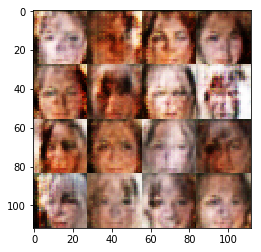

Epoch 1/1... Discriminator Loss: 1.2013... Generator Loss: 1.1173
Epoch 1/1... Discriminator Loss: 1.3046... Generator Loss: 1.1199
Epoch 1/1... Discriminator Loss: 1.0881... Generator Loss: 1.1915
Epoch 1/1... Discriminator Loss: 1.1369... Generator Loss: 0.6946
Epoch 1/1... Discriminator Loss: 1.2552... Generator Loss: 1.1052
Epoch 1/1... Discriminator Loss: 1.2037... Generator Loss: 1.2086
Epoch 1/1... Discriminator Loss: 1.2164... Generator Loss: 1.4615
Epoch 1/1... Discriminator Loss: 1.0649... Generator Loss: 1.1503
Epoch 1/1... Discriminator Loss: 1.0457... Generator Loss: 1.2925
Epoch 1/1... Discriminator Loss: 1.2251... Generator Loss: 0.8537


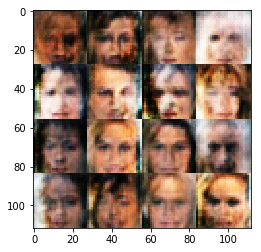

Epoch 1/1... Discriminator Loss: 1.1447... Generator Loss: 0.9751
Epoch 1/1... Discriminator Loss: 1.0076... Generator Loss: 1.4626
Epoch 1/1... Discriminator Loss: 0.9624... Generator Loss: 0.9858
Epoch 1/1... Discriminator Loss: 1.3242... Generator Loss: 1.5368
Epoch 1/1... Discriminator Loss: 1.1025... Generator Loss: 1.0760
Epoch 1/1... Discriminator Loss: 1.4004... Generator Loss: 0.8054
Epoch 1/1... Discriminator Loss: 1.3602... Generator Loss: 1.1948
Epoch 1/1... Discriminator Loss: 1.1440... Generator Loss: 1.1119
Epoch 1/1... Discriminator Loss: 1.2152... Generator Loss: 0.8352
Epoch 1/1... Discriminator Loss: 1.2314... Generator Loss: 0.8332


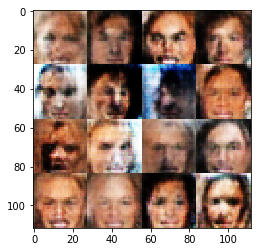

Epoch 1/1... Discriminator Loss: 1.5151... Generator Loss: 1.8473
Epoch 1/1... Discriminator Loss: 1.1575... Generator Loss: 0.7381
Epoch 1/1... Discriminator Loss: 0.7613... Generator Loss: 1.4157
Epoch 1/1... Discriminator Loss: 1.4905... Generator Loss: 0.8557
Epoch 1/1... Discriminator Loss: 1.6634... Generator Loss: 1.4611
Epoch 1/1... Discriminator Loss: 1.1008... Generator Loss: 1.2167
Epoch 1/1... Discriminator Loss: 1.2095... Generator Loss: 1.2026
Epoch 1/1... Discriminator Loss: 1.1386... Generator Loss: 0.8208
Epoch 1/1... Discriminator Loss: 1.2047... Generator Loss: 0.9334
Epoch 1/1... Discriminator Loss: 1.4654... Generator Loss: 0.9134


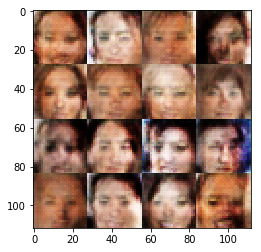

Epoch 1/1... Discriminator Loss: 1.4194... Generator Loss: 0.7868
Epoch 1/1... Discriminator Loss: 1.0880... Generator Loss: 0.9834
Epoch 1/1... Discriminator Loss: 1.2015... Generator Loss: 0.7496
Epoch 1/1... Discriminator Loss: 1.3473... Generator Loss: 1.4526
Epoch 1/1... Discriminator Loss: 1.3294... Generator Loss: 0.9848
Epoch 1/1... Discriminator Loss: 1.4788... Generator Loss: 0.7321
Epoch 1/1... Discriminator Loss: 1.1198... Generator Loss: 1.7247
Epoch 1/1... Discriminator Loss: 1.1378... Generator Loss: 1.6826
Epoch 1/1... Discriminator Loss: 1.3976... Generator Loss: 0.9445
Epoch 1/1... Discriminator Loss: 1.0933... Generator Loss: 1.0344


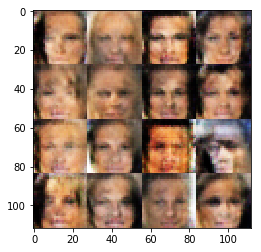

Epoch 1/1... Discriminator Loss: 1.3966... Generator Loss: 0.9711
Epoch 1/1... Discriminator Loss: 1.4274... Generator Loss: 0.7060
Epoch 1/1... Discriminator Loss: 1.0804... Generator Loss: 1.0865
Epoch 1/1... Discriminator Loss: 0.8620... Generator Loss: 1.2404
Epoch 1/1... Discriminator Loss: 1.4504... Generator Loss: 0.8592
Epoch 1/1... Discriminator Loss: 1.0012... Generator Loss: 1.0799
Epoch 1/1... Discriminator Loss: 1.1673... Generator Loss: 0.8264
Epoch 1/1... Discriminator Loss: 1.3062... Generator Loss: 1.5155
Epoch 1/1... Discriminator Loss: 1.5829... Generator Loss: 1.0001
Epoch 1/1... Discriminator Loss: 1.3344... Generator Loss: 1.1591


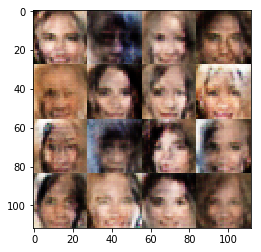

Epoch 1/1... Discriminator Loss: 1.4230... Generator Loss: 0.9098
Epoch 1/1... Discriminator Loss: 1.0429... Generator Loss: 1.1044
Epoch 1/1... Discriminator Loss: 0.8885... Generator Loss: 1.0328
Epoch 1/1... Discriminator Loss: 1.0923... Generator Loss: 1.0957
Epoch 1/1... Discriminator Loss: 1.0727... Generator Loss: 0.9655
Epoch 1/1... Discriminator Loss: 1.4333... Generator Loss: 1.5208
Epoch 1/1... Discriminator Loss: 1.0368... Generator Loss: 0.9445
Epoch 1/1... Discriminator Loss: 1.1690... Generator Loss: 1.0475
Epoch 1/1... Discriminator Loss: 1.1525... Generator Loss: 0.8253
Epoch 1/1... Discriminator Loss: 1.4802... Generator Loss: 1.3067


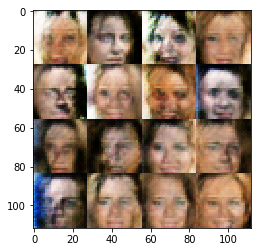

Epoch 1/1... Discriminator Loss: 1.4993... Generator Loss: 0.6288
Epoch 1/1... Discriminator Loss: 1.3009... Generator Loss: 0.9298
Epoch 1/1... Discriminator Loss: 1.3438... Generator Loss: 0.8267
Epoch 1/1... Discriminator Loss: 1.0457... Generator Loss: 1.0743
Epoch 1/1... Discriminator Loss: 1.6283... Generator Loss: 0.6218
Epoch 1/1... Discriminator Loss: 1.3924... Generator Loss: 1.1279
Epoch 1/1... Discriminator Loss: 2.1451... Generator Loss: 2.0089
Epoch 1/1... Discriminator Loss: 1.1687... Generator Loss: 0.9455
Epoch 1/1... Discriminator Loss: 1.1971... Generator Loss: 1.1140
Epoch 1/1... Discriminator Loss: 1.2727... Generator Loss: 1.0587


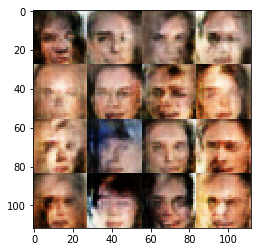

Epoch 1/1... Discriminator Loss: 1.3935... Generator Loss: 1.1641
Epoch 1/1... Discriminator Loss: 1.4241... Generator Loss: 0.9033
Epoch 1/1... Discriminator Loss: 1.2159... Generator Loss: 0.7590
Epoch 1/1... Discriminator Loss: 1.0993... Generator Loss: 0.7499
Epoch 1/1... Discriminator Loss: 1.2740... Generator Loss: 0.9182
Epoch 1/1... Discriminator Loss: 0.9546... Generator Loss: 1.1812
Epoch 1/1... Discriminator Loss: 1.5595... Generator Loss: 1.0036
Epoch 1/1... Discriminator Loss: 1.3594... Generator Loss: 0.7734
Epoch 1/1... Discriminator Loss: 1.4631... Generator Loss: 0.8633
Epoch 1/1... Discriminator Loss: 1.0811... Generator Loss: 0.9363


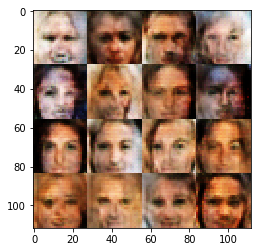

Epoch 1/1... Discriminator Loss: 1.3531... Generator Loss: 1.0389
Epoch 1/1... Discriminator Loss: 1.3782... Generator Loss: 1.2037
Epoch 1/1... Discriminator Loss: 1.2598... Generator Loss: 0.9727
Epoch 1/1... Discriminator Loss: 0.9982... Generator Loss: 1.0655
Epoch 1/1... Discriminator Loss: 1.2882... Generator Loss: 0.9341
Epoch 1/1... Discriminator Loss: 1.2032... Generator Loss: 1.1078
Epoch 1/1... Discriminator Loss: 1.2422... Generator Loss: 0.7946
Epoch 1/1... Discriminator Loss: 1.2518... Generator Loss: 1.2518
Epoch 1/1... Discriminator Loss: 1.4301... Generator Loss: 0.5841
Epoch 1/1... Discriminator Loss: 1.1815... Generator Loss: 0.8159


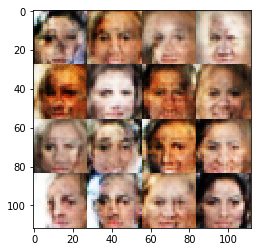

Epoch 1/1... Discriminator Loss: 1.3166... Generator Loss: 1.1511
Epoch 1/1... Discriminator Loss: 1.1778... Generator Loss: 0.8148
Epoch 1/1... Discriminator Loss: 0.9315... Generator Loss: 0.9701
Epoch 1/1... Discriminator Loss: 1.4256... Generator Loss: 1.3443
Epoch 1/1... Discriminator Loss: 1.3050... Generator Loss: 0.9408
Epoch 1/1... Discriminator Loss: 1.3899... Generator Loss: 0.6862
Epoch 1/1... Discriminator Loss: 1.1232... Generator Loss: 1.4502
Epoch 1/1... Discriminator Loss: 1.1330... Generator Loss: 0.9762
Epoch 1/1... Discriminator Loss: 1.0482... Generator Loss: 0.9459
Epoch 1/1... Discriminator Loss: 1.2357... Generator Loss: 0.8838


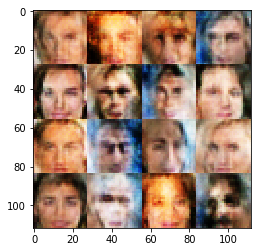

Epoch 1/1... Discriminator Loss: 1.2939... Generator Loss: 1.0873
Epoch 1/1... Discriminator Loss: 1.2541... Generator Loss: 0.7997
Epoch 1/1... Discriminator Loss: 1.2252... Generator Loss: 0.8078
Epoch 1/1... Discriminator Loss: 1.3069... Generator Loss: 0.8152
Epoch 1/1... Discriminator Loss: 1.2256... Generator Loss: 0.9331
Epoch 1/1... Discriminator Loss: 1.4847... Generator Loss: 0.6619
Epoch 1/1... Discriminator Loss: 1.5152... Generator Loss: 0.6189
Epoch 1/1... Discriminator Loss: 1.1764... Generator Loss: 1.5724
Epoch 1/1... Discriminator Loss: 1.7595... Generator Loss: 0.4906
Epoch 1/1... Discriminator Loss: 1.3263... Generator Loss: 0.6307


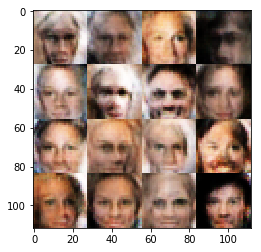

Epoch 1/1... Discriminator Loss: 1.3033... Generator Loss: 1.1648
Epoch 1/1... Discriminator Loss: 1.2172... Generator Loss: 1.1062
Epoch 1/1... Discriminator Loss: 1.2022... Generator Loss: 1.0998
Epoch 1/1... Discriminator Loss: 1.0646... Generator Loss: 1.1940
Epoch 1/1... Discriminator Loss: 1.2317... Generator Loss: 0.7389
Epoch 1/1... Discriminator Loss: 1.6472... Generator Loss: 1.6137
Epoch 1/1... Discriminator Loss: 1.1811... Generator Loss: 1.4693
Epoch 1/1... Discriminator Loss: 1.3048... Generator Loss: 0.7735
Epoch 1/1... Discriminator Loss: 1.2687... Generator Loss: 1.0797
Epoch 1/1... Discriminator Loss: 1.6848... Generator Loss: 2.1103


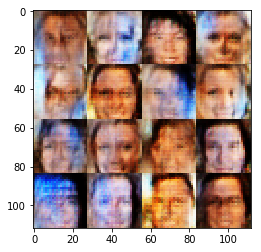

Epoch 1/1... Discriminator Loss: 1.1073... Generator Loss: 0.9493
Epoch 1/1... Discriminator Loss: 1.2246... Generator Loss: 1.3401
Epoch 1/1... Discriminator Loss: 1.2264... Generator Loss: 0.7065
Epoch 1/1... Discriminator Loss: 1.0361... Generator Loss: 0.9690
Epoch 1/1... Discriminator Loss: 1.1427... Generator Loss: 1.0234
Epoch 1/1... Discriminator Loss: 1.2826... Generator Loss: 0.6395
Epoch 1/1... Discriminator Loss: 1.1658... Generator Loss: 0.7741
Epoch 1/1... Discriminator Loss: 1.5889... Generator Loss: 0.7131
Epoch 1/1... Discriminator Loss: 1.0380... Generator Loss: 1.3914
Epoch 1/1... Discriminator Loss: 1.5392... Generator Loss: 0.8472


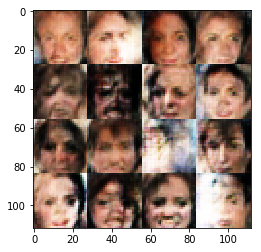

Epoch 1/1... Discriminator Loss: 0.9425... Generator Loss: 1.0698
Epoch 1/1... Discriminator Loss: 1.0978... Generator Loss: 1.1415
Epoch 1/1... Discriminator Loss: 0.8737... Generator Loss: 1.1390
Epoch 1/1... Discriminator Loss: 1.4096... Generator Loss: 1.3526
Epoch 1/1... Discriminator Loss: 1.1093... Generator Loss: 0.9754
Epoch 1/1... Discriminator Loss: 1.0977... Generator Loss: 0.9324
Epoch 1/1... Discriminator Loss: 1.1350... Generator Loss: 0.9888
Epoch 1/1... Discriminator Loss: 1.2893... Generator Loss: 0.8509
Epoch 1/1... Discriminator Loss: 1.4165... Generator Loss: 0.6800
Epoch 1/1... Discriminator Loss: 1.2949... Generator Loss: 1.4268


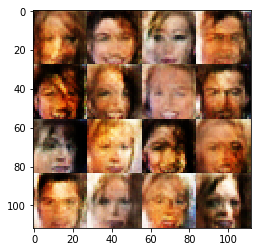

Epoch 1/1... Discriminator Loss: 1.0339... Generator Loss: 1.2459
Epoch 1/1... Discriminator Loss: 1.1003... Generator Loss: 1.0411
Epoch 1/1... Discriminator Loss: 1.6440... Generator Loss: 0.5938
Epoch 1/1... Discriminator Loss: 1.3066... Generator Loss: 0.9192
Epoch 1/1... Discriminator Loss: 1.3311... Generator Loss: 1.5545
Epoch 1/1... Discriminator Loss: 1.2967... Generator Loss: 0.9559
Epoch 1/1... Discriminator Loss: 0.9509... Generator Loss: 1.2117
Epoch 1/1... Discriminator Loss: 1.1837... Generator Loss: 1.2507
Epoch 1/1... Discriminator Loss: 1.2588... Generator Loss: 0.8815
Epoch 1/1... Discriminator Loss: 1.3735... Generator Loss: 0.7503


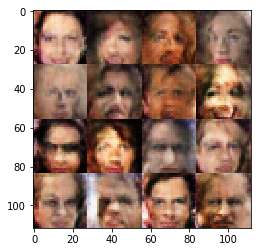

Epoch 1/1... Discriminator Loss: 1.3207... Generator Loss: 1.0952
Epoch 1/1... Discriminator Loss: 1.4869... Generator Loss: 0.7353
Epoch 1/1... Discriminator Loss: 1.0813... Generator Loss: 1.1902
Epoch 1/1... Discriminator Loss: 1.1393... Generator Loss: 1.0521
Epoch 1/1... Discriminator Loss: 1.2721... Generator Loss: 0.9064
Epoch 1/1... Discriminator Loss: 1.2028... Generator Loss: 0.9942
Epoch 1/1... Discriminator Loss: 1.2463... Generator Loss: 1.4475
Epoch 1/1... Discriminator Loss: 1.3715... Generator Loss: 1.0792
Epoch 1/1... Discriminator Loss: 1.2954... Generator Loss: 0.9042
Epoch 1/1... Discriminator Loss: 1.2789... Generator Loss: 0.8244


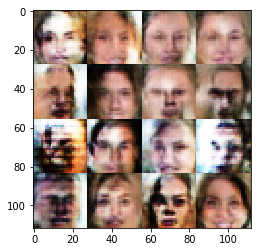

Epoch 1/1... Discriminator Loss: 1.1426... Generator Loss: 1.2716
Epoch 1/1... Discriminator Loss: 1.1193... Generator Loss: 1.0134
Epoch 1/1... Discriminator Loss: 0.8482... Generator Loss: 1.4706
Epoch 1/1... Discriminator Loss: 1.3400... Generator Loss: 1.6361
Epoch 1/1... Discriminator Loss: 1.0814... Generator Loss: 0.8039
Epoch 1/1... Discriminator Loss: 1.2381... Generator Loss: 0.9585
Epoch 1/1... Discriminator Loss: 1.2013... Generator Loss: 0.8802
Epoch 1/1... Discriminator Loss: 1.2142... Generator Loss: 1.0840
Epoch 1/1... Discriminator Loss: 0.8716... Generator Loss: 1.0588
Epoch 1/1... Discriminator Loss: 1.0740... Generator Loss: 1.4707


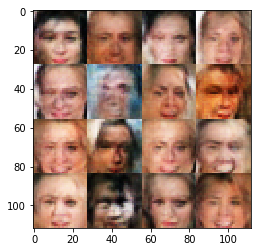

Epoch 1/1... Discriminator Loss: 0.9304... Generator Loss: 1.1355
Epoch 1/1... Discriminator Loss: 1.2182... Generator Loss: 1.1252
Epoch 1/1... Discriminator Loss: 1.2359... Generator Loss: 0.9176
Epoch 1/1... Discriminator Loss: 1.2400... Generator Loss: 1.1464
Epoch 1/1... Discriminator Loss: 1.1852... Generator Loss: 0.8102
Epoch 1/1... Discriminator Loss: 0.9958... Generator Loss: 1.4061
Epoch 1/1... Discriminator Loss: 1.2301... Generator Loss: 1.3693
Epoch 1/1... Discriminator Loss: 1.3942... Generator Loss: 0.9996
Epoch 1/1... Discriminator Loss: 1.1979... Generator Loss: 1.4509
Epoch 1/1... Discriminator Loss: 1.2370... Generator Loss: 0.9217


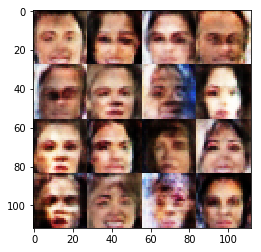

Epoch 1/1... Discriminator Loss: 1.3624... Generator Loss: 0.8670
Epoch 1/1... Discriminator Loss: 1.2397... Generator Loss: 1.0904
Epoch 1/1... Discriminator Loss: 1.1304... Generator Loss: 1.0035
Epoch 1/1... Discriminator Loss: 1.2131... Generator Loss: 0.6493
Epoch 1/1... Discriminator Loss: 1.2112... Generator Loss: 1.3965
Epoch 1/1... Discriminator Loss: 1.0795... Generator Loss: 0.8600
Epoch 1/1... Discriminator Loss: 1.1918... Generator Loss: 1.0746
Epoch 1/1... Discriminator Loss: 1.2996... Generator Loss: 0.7254
Epoch 1/1... Discriminator Loss: 1.2365... Generator Loss: 0.9964
Epoch 1/1... Discriminator Loss: 1.3518... Generator Loss: 0.9696


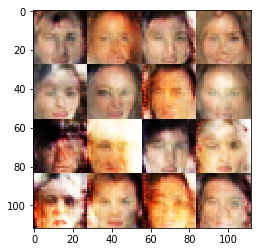

Epoch 1/1... Discriminator Loss: 1.0928... Generator Loss: 1.1346
Epoch 1/1... Discriminator Loss: 1.1994... Generator Loss: 0.9321
Epoch 1/1... Discriminator Loss: 1.2080... Generator Loss: 1.1683
Epoch 1/1... Discriminator Loss: 1.1171... Generator Loss: 0.9976
Epoch 1/1... Discriminator Loss: 1.2539... Generator Loss: 0.8622
Epoch 1/1... Discriminator Loss: 1.2409... Generator Loss: 0.8608
Epoch 1/1... Discriminator Loss: 1.0233... Generator Loss: 0.9237
Epoch 1/1... Discriminator Loss: 1.5510... Generator Loss: 1.2141
Epoch 1/1... Discriminator Loss: 1.2153... Generator Loss: 1.1875
Epoch 1/1... Discriminator Loss: 0.9815... Generator Loss: 0.9290


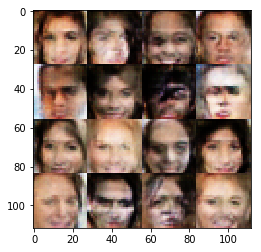

Epoch 1/1... Discriminator Loss: 1.2741... Generator Loss: 0.8665
Epoch 1/1... Discriminator Loss: 1.0641... Generator Loss: 0.9333
Epoch 1/1... Discriminator Loss: 1.2238... Generator Loss: 0.9867
Epoch 1/1... Discriminator Loss: 1.3411... Generator Loss: 1.0698
Epoch 1/1... Discriminator Loss: 1.0187... Generator Loss: 0.9897
Epoch 1/1... Discriminator Loss: 1.3189... Generator Loss: 0.8421
Epoch 1/1... Discriminator Loss: 1.2784... Generator Loss: 0.9650
Epoch 1/1... Discriminator Loss: 1.1583... Generator Loss: 0.9708
Epoch 1/1... Discriminator Loss: 1.0486... Generator Loss: 0.7256
Epoch 1/1... Discriminator Loss: 1.3355... Generator Loss: 1.1405


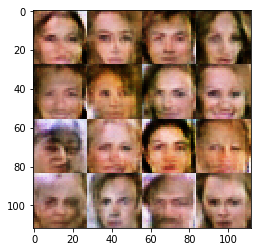

Epoch 1/1... Discriminator Loss: 1.3921... Generator Loss: 1.3892
Epoch 1/1... Discriminator Loss: 1.0822... Generator Loss: 0.9344
Epoch 1/1... Discriminator Loss: 1.0983... Generator Loss: 0.9557
Epoch 1/1... Discriminator Loss: 1.5504... Generator Loss: 1.3823
Epoch 1/1... Discriminator Loss: 1.3683... Generator Loss: 1.2235
Epoch 1/1... Discriminator Loss: 1.0809... Generator Loss: 0.9468
Epoch 1/1... Discriminator Loss: 1.3611... Generator Loss: 1.0544
Epoch 1/1... Discriminator Loss: 1.3783... Generator Loss: 0.9972
Epoch 1/1... Discriminator Loss: 1.2664... Generator Loss: 0.6674
Epoch 1/1... Discriminator Loss: 1.4282... Generator Loss: 0.7731


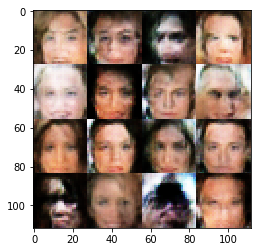

Epoch 1/1... Discriminator Loss: 1.2557... Generator Loss: 0.6945
Epoch 1/1... Discriminator Loss: 1.2471... Generator Loss: 1.1400
Epoch 1/1... Discriminator Loss: 1.0485... Generator Loss: 1.0589
Epoch 1/1... Discriminator Loss: 1.5317... Generator Loss: 1.8539
Epoch 1/1... Discriminator Loss: 2.0369... Generator Loss: 1.4142
Epoch 1/1... Discriminator Loss: 1.1566... Generator Loss: 0.9969
Epoch 1/1... Discriminator Loss: 1.4055... Generator Loss: 0.8023
Epoch 1/1... Discriminator Loss: 1.0788... Generator Loss: 1.0633
Epoch 1/1... Discriminator Loss: 1.4640... Generator Loss: 0.7635
Epoch 1/1... Discriminator Loss: 1.3245... Generator Loss: 1.1320


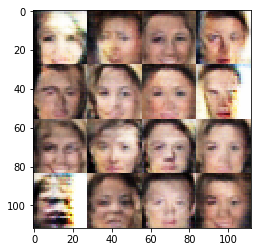

Epoch 1/1... Discriminator Loss: 1.1681... Generator Loss: 0.8683
Epoch 1/1... Discriminator Loss: 1.2134... Generator Loss: 0.9417
Epoch 1/1... Discriminator Loss: 1.2728... Generator Loss: 1.2469
Epoch 1/1... Discriminator Loss: 1.3213... Generator Loss: 0.8593
Epoch 1/1... Discriminator Loss: 0.9775... Generator Loss: 1.0064
Epoch 1/1... Discriminator Loss: 1.3807... Generator Loss: 1.0361
Epoch 1/1... Discriminator Loss: 1.0964... Generator Loss: 1.1607
Epoch 1/1... Discriminator Loss: 0.9508... Generator Loss: 0.9071
Epoch 1/1... Discriminator Loss: 1.2368... Generator Loss: 0.9715
Epoch 1/1... Discriminator Loss: 1.3263... Generator Loss: 1.1618


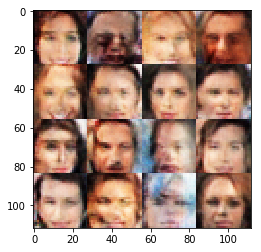

Epoch 1/1... Discriminator Loss: 1.1036... Generator Loss: 0.8388
Epoch 1/1... Discriminator Loss: 1.2917... Generator Loss: 0.6883
Epoch 1/1... Discriminator Loss: 1.1841... Generator Loss: 1.0830
Epoch 1/1... Discriminator Loss: 1.2650... Generator Loss: 0.8908
Epoch 1/1... Discriminator Loss: 1.2158... Generator Loss: 0.9050
Epoch 1/1... Discriminator Loss: 1.1395... Generator Loss: 0.8410
Epoch 1/1... Discriminator Loss: 1.0984... Generator Loss: 1.1831
Epoch 1/1... Discriminator Loss: 0.9304... Generator Loss: 0.8781
Epoch 1/1... Discriminator Loss: 1.3071... Generator Loss: 1.1721
Epoch 1/1... Discriminator Loss: 1.0499... Generator Loss: 0.9562


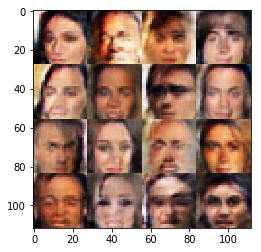

Epoch 1/1... Discriminator Loss: 1.3759... Generator Loss: 0.7863
Epoch 1/1... Discriminator Loss: 1.1890... Generator Loss: 0.8208
Epoch 1/1... Discriminator Loss: 1.1987... Generator Loss: 0.9712
Epoch 1/1... Discriminator Loss: 1.0495... Generator Loss: 1.1469
Epoch 1/1... Discriminator Loss: 0.8486... Generator Loss: 1.0224
Epoch 1/1... Discriminator Loss: 1.1849... Generator Loss: 0.8365
Epoch 1/1... Discriminator Loss: 1.0609... Generator Loss: 1.1221
Epoch 1/1... Discriminator Loss: 0.9686... Generator Loss: 0.8354
Epoch 1/1... Discriminator Loss: 1.1778... Generator Loss: 1.1595
Epoch 1/1... Discriminator Loss: 1.4551... Generator Loss: 0.7506


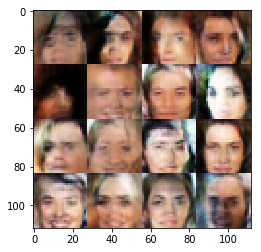

Epoch 1/1... Discriminator Loss: 1.0121... Generator Loss: 1.0280
Epoch 1/1... Discriminator Loss: 1.2028... Generator Loss: 0.9447
Epoch 1/1... Discriminator Loss: 1.1233... Generator Loss: 1.0723
Epoch 1/1... Discriminator Loss: 1.1197... Generator Loss: 0.8255
Epoch 1/1... Discriminator Loss: 1.3994... Generator Loss: 1.6339
Epoch 1/1... Discriminator Loss: 1.2686... Generator Loss: 0.8362
Epoch 1/1... Discriminator Loss: 0.9582... Generator Loss: 1.1101
Epoch 1/1... Discriminator Loss: 1.3857... Generator Loss: 0.5907
Epoch 1/1... Discriminator Loss: 1.5096... Generator Loss: 1.0004
Epoch 1/1... Discriminator Loss: 1.2986... Generator Loss: 0.9932


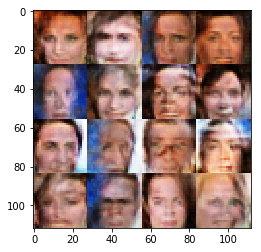

Epoch 1/1... Discriminator Loss: 1.3413... Generator Loss: 0.9618
Epoch 1/1... Discriminator Loss: 1.2561... Generator Loss: 0.6246
Epoch 1/1... Discriminator Loss: 1.3365... Generator Loss: 1.1106
Epoch 1/1... Discriminator Loss: 1.5625... Generator Loss: 0.7588
Epoch 1/1... Discriminator Loss: 1.2004... Generator Loss: 0.8993
Epoch 1/1... Discriminator Loss: 1.0856... Generator Loss: 0.8979
Epoch 1/1... Discriminator Loss: 1.1409... Generator Loss: 1.1836
Epoch 1/1... Discriminator Loss: 1.2778... Generator Loss: 0.8570
Epoch 1/1... Discriminator Loss: 1.1013... Generator Loss: 0.9815
Epoch 1/1... Discriminator Loss: 1.2887... Generator Loss: 1.1170


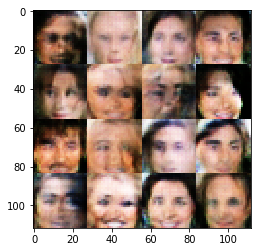

Epoch 1/1... Discriminator Loss: 1.2899... Generator Loss: 0.7284
Epoch 1/1... Discriminator Loss: 1.2784... Generator Loss: 1.0633
Epoch 1/1... Discriminator Loss: 0.8432... Generator Loss: 1.0763
Epoch 1/1... Discriminator Loss: 1.2616... Generator Loss: 1.1827
Epoch 1/1... Discriminator Loss: 1.1779... Generator Loss: 0.8026
Epoch 1/1... Discriminator Loss: 1.0754... Generator Loss: 0.8248
Epoch 1/1... Discriminator Loss: 1.3050... Generator Loss: 0.8885
Epoch 1/1... Discriminator Loss: 1.2954... Generator Loss: 0.7490
Epoch 1/1... Discriminator Loss: 1.2139... Generator Loss: 0.9012
Epoch 1/1... Discriminator Loss: 1.6707... Generator Loss: 0.7852


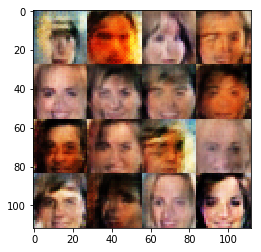

Epoch 1/1... Discriminator Loss: 1.2285... Generator Loss: 1.0231
Epoch 1/1... Discriminator Loss: 1.2022... Generator Loss: 1.4770
Epoch 1/1... Discriminator Loss: 1.1562... Generator Loss: 1.0463
Epoch 1/1... Discriminator Loss: 1.3170... Generator Loss: 1.3591
Epoch 1/1... Discriminator Loss: 1.1739... Generator Loss: 0.9912
Epoch 1/1... Discriminator Loss: 1.6706... Generator Loss: 0.5314
Epoch 1/1... Discriminator Loss: 1.1306... Generator Loss: 0.8787
Epoch 1/1... Discriminator Loss: 1.3881... Generator Loss: 0.9299
Epoch 1/1... Discriminator Loss: 1.1695... Generator Loss: 1.1265
Epoch 1/1... Discriminator Loss: 1.1087... Generator Loss: 0.9204


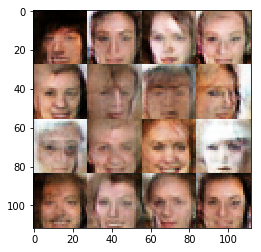

Epoch 1/1... Discriminator Loss: 1.1768... Generator Loss: 1.4634
Epoch 1/1... Discriminator Loss: 1.1283... Generator Loss: 0.8254
Epoch 1/1... Discriminator Loss: 1.0366... Generator Loss: 1.0116
Epoch 1/1... Discriminator Loss: 1.2416... Generator Loss: 1.2018
Epoch 1/1... Discriminator Loss: 1.3805... Generator Loss: 0.7427
Epoch 1/1... Discriminator Loss: 0.9471... Generator Loss: 0.9892
Epoch 1/1... Discriminator Loss: 0.9413... Generator Loss: 0.9834
Epoch 1/1... Discriminator Loss: 1.1478... Generator Loss: 0.9051
Epoch 1/1... Discriminator Loss: 1.0196... Generator Loss: 1.0958
Epoch 1/1... Discriminator Loss: 1.0795... Generator Loss: 0.8181


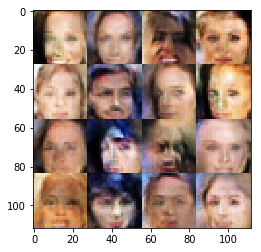

Epoch 1/1... Discriminator Loss: 1.2671... Generator Loss: 0.9814
Epoch 1/1... Discriminator Loss: 1.3110... Generator Loss: 1.0346
Epoch 1/1... Discriminator Loss: 1.0546... Generator Loss: 0.9667
Epoch 1/1... Discriminator Loss: 1.0051... Generator Loss: 0.8249
Epoch 1/1... Discriminator Loss: 1.0321... Generator Loss: 0.7954
Epoch 1/1... Discriminator Loss: 1.2557... Generator Loss: 0.8548
Epoch 1/1... Discriminator Loss: 1.1167... Generator Loss: 0.9907
Epoch 1/1... Discriminator Loss: 1.3605... Generator Loss: 0.5975
Epoch 1/1... Discriminator Loss: 1.2248... Generator Loss: 0.8983
Epoch 1/1... Discriminator Loss: 1.0770... Generator Loss: 0.9761


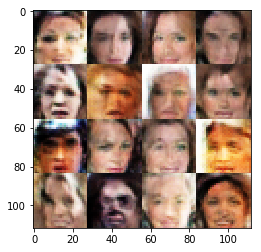

Epoch 1/1... Discriminator Loss: 1.2078... Generator Loss: 0.9699
Epoch 1/1... Discriminator Loss: 1.3684... Generator Loss: 0.8207
Epoch 1/1... Discriminator Loss: 1.2665... Generator Loss: 0.7624
Epoch 1/1... Discriminator Loss: 1.2114... Generator Loss: 0.6851
Epoch 1/1... Discriminator Loss: 1.2070... Generator Loss: 0.9545
Epoch 1/1... Discriminator Loss: 1.2043... Generator Loss: 1.4080
Epoch 1/1... Discriminator Loss: 1.1770... Generator Loss: 0.9890
Epoch 1/1... Discriminator Loss: 1.0451... Generator Loss: 1.0229
Epoch 1/1... Discriminator Loss: 1.3224... Generator Loss: 0.9791
Epoch 1/1... Discriminator Loss: 1.2271... Generator Loss: 1.0548


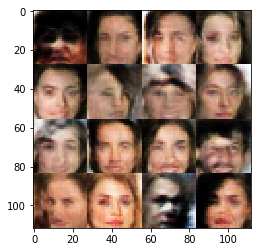

Epoch 1/1... Discriminator Loss: 1.3415... Generator Loss: 0.9395
Epoch 1/1... Discriminator Loss: 1.0946... Generator Loss: 1.1088
Epoch 1/1... Discriminator Loss: 1.1262... Generator Loss: 0.8923
Epoch 1/1... Discriminator Loss: 1.0202... Generator Loss: 1.2554
Epoch 1/1... Discriminator Loss: 1.1858... Generator Loss: 1.1002
Epoch 1/1... Discriminator Loss: 1.1731... Generator Loss: 0.9274
Epoch 1/1... Discriminator Loss: 1.1099... Generator Loss: 1.2095
Epoch 1/1... Discriminator Loss: 1.2524... Generator Loss: 0.8815
Epoch 1/1... Discriminator Loss: 1.1163... Generator Loss: 1.1440
Epoch 1/1... Discriminator Loss: 1.2852... Generator Loss: 0.9556


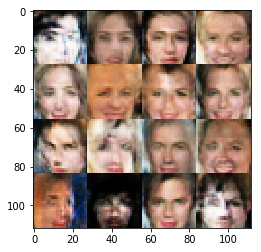

Epoch 1/1... Discriminator Loss: 1.2340... Generator Loss: 0.9442
Epoch 1/1... Discriminator Loss: 1.1961... Generator Loss: 1.1694
Epoch 1/1... Discriminator Loss: 1.3215... Generator Loss: 0.8705
Epoch 1/1... Discriminator Loss: 1.3161... Generator Loss: 0.9944
Epoch 1/1... Discriminator Loss: 1.4524... Generator Loss: 0.9411
Epoch 1/1... Discriminator Loss: 1.2647... Generator Loss: 0.8974
Epoch 1/1... Discriminator Loss: 1.2044... Generator Loss: 0.9738
Epoch 1/1... Discriminator Loss: 1.1369... Generator Loss: 0.9617
Epoch 1/1... Discriminator Loss: 1.3798... Generator Loss: 0.7797
Epoch 1/1... Discriminator Loss: 1.1375... Generator Loss: 1.1658


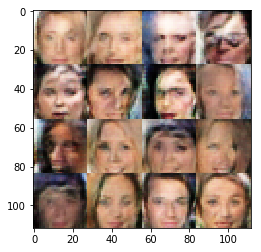

Epoch 1/1... Discriminator Loss: 1.5689... Generator Loss: 1.0875
Epoch 1/1... Discriminator Loss: 1.2291... Generator Loss: 1.0156
Epoch 1/1... Discriminator Loss: 1.1724... Generator Loss: 0.7778
Epoch 1/1... Discriminator Loss: 1.1702... Generator Loss: 1.0217
Epoch 1/1... Discriminator Loss: 1.2248... Generator Loss: 1.3454
Epoch 1/1... Discriminator Loss: 1.1746... Generator Loss: 1.2196
Epoch 1/1... Discriminator Loss: 1.2956... Generator Loss: 0.9107
Epoch 1/1... Discriminator Loss: 0.9957... Generator Loss: 1.0667
Epoch 1/1... Discriminator Loss: 1.2649... Generator Loss: 0.8276
Epoch 1/1... Discriminator Loss: 1.3082... Generator Loss: 0.8518


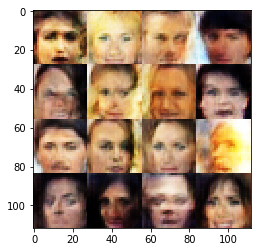

Epoch 1/1... Discriminator Loss: 1.2836... Generator Loss: 0.7488
Epoch 1/1... Discriminator Loss: 0.9886... Generator Loss: 1.0638
Epoch 1/1... Discriminator Loss: 1.1871... Generator Loss: 0.8942
Epoch 1/1... Discriminator Loss: 1.1753... Generator Loss: 0.9452
Epoch 1/1... Discriminator Loss: 1.4225... Generator Loss: 0.7045
Epoch 1/1... Discriminator Loss: 1.3046... Generator Loss: 0.8816
Epoch 1/1... Discriminator Loss: 1.0567... Generator Loss: 1.0704
Epoch 1/1... Discriminator Loss: 1.2256... Generator Loss: 1.1199
Epoch 1/1... Discriminator Loss: 1.2401... Generator Loss: 0.9621
Epoch 1/1... Discriminator Loss: 1.2881... Generator Loss: 1.0433


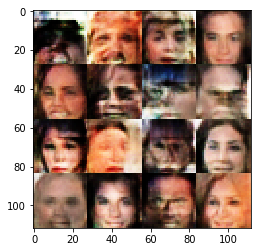

Epoch 1/1... Discriminator Loss: 1.0147... Generator Loss: 0.9384
Epoch 1/1... Discriminator Loss: 1.0190... Generator Loss: 1.0559
Epoch 1/1... Discriminator Loss: 1.4535... Generator Loss: 0.9343
Epoch 1/1... Discriminator Loss: 1.0545... Generator Loss: 0.9613
Epoch 1/1... Discriminator Loss: 1.3366... Generator Loss: 0.7886
Epoch 1/1... Discriminator Loss: 1.1692... Generator Loss: 1.0045
Epoch 1/1... Discriminator Loss: 1.0004... Generator Loss: 1.2556
Epoch 1/1... Discriminator Loss: 1.3002... Generator Loss: 0.8834
Epoch 1/1... Discriminator Loss: 1.1598... Generator Loss: 1.0331
Epoch 1/1... Discriminator Loss: 1.2833... Generator Loss: 0.8125


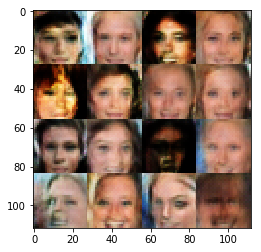

Epoch 1/1... Discriminator Loss: 1.3611... Generator Loss: 1.4440
Epoch 1/1... Discriminator Loss: 1.2170... Generator Loss: 0.9969
Epoch 1/1... Discriminator Loss: 1.1757... Generator Loss: 0.8704
Epoch 1/1... Discriminator Loss: 1.0357... Generator Loss: 0.8737
Epoch 1/1... Discriminator Loss: 1.0321... Generator Loss: 1.1287
Epoch 1/1... Discriminator Loss: 1.1372... Generator Loss: 0.9019
Epoch 1/1... Discriminator Loss: 1.2793... Generator Loss: 0.8685
Epoch 1/1... Discriminator Loss: 1.0502... Generator Loss: 1.1470
Epoch 1/1... Discriminator Loss: 1.0796... Generator Loss: 1.2208
Epoch 1/1... Discriminator Loss: 1.2071... Generator Loss: 0.8437


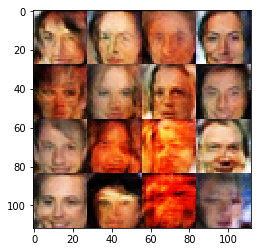

Epoch 1/1... Discriminator Loss: 1.0440... Generator Loss: 1.0595
Epoch 1/1... Discriminator Loss: 1.2644... Generator Loss: 0.6896
Epoch 1/1... Discriminator Loss: 0.9800... Generator Loss: 0.9444
Epoch 1/1... Discriminator Loss: 0.9478... Generator Loss: 1.0773
Epoch 1/1... Discriminator Loss: 1.0736... Generator Loss: 0.9145
Epoch 1/1... Discriminator Loss: 1.8693... Generator Loss: 2.4600
Epoch 1/1... Discriminator Loss: 1.3269... Generator Loss: 1.0487
Epoch 1/1... Discriminator Loss: 1.0797... Generator Loss: 0.9398
Epoch 1/1... Discriminator Loss: 1.1520... Generator Loss: 0.9998
Epoch 1/1... Discriminator Loss: 1.0623... Generator Loss: 1.5238


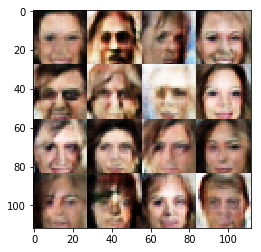

Epoch 1/1... Discriminator Loss: 1.4418... Generator Loss: 1.2453
Epoch 1/1... Discriminator Loss: 0.9641... Generator Loss: 1.0008
Epoch 1/1... Discriminator Loss: 0.9890... Generator Loss: 1.0881
Epoch 1/1... Discriminator Loss: 1.1017... Generator Loss: 0.8356
Epoch 1/1... Discriminator Loss: 1.1300... Generator Loss: 1.3759
Epoch 1/1... Discriminator Loss: 1.3217... Generator Loss: 0.9370
Epoch 1/1... Discriminator Loss: 1.3567... Generator Loss: 0.8259
Epoch 1/1... Discriminator Loss: 1.0831... Generator Loss: 1.1098
Epoch 1/1... Discriminator Loss: 1.2758... Generator Loss: 1.0609
Epoch 1/1... Discriminator Loss: 1.2780... Generator Loss: 0.9133


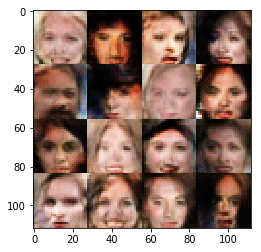

Epoch 1/1... Discriminator Loss: 1.2387... Generator Loss: 1.1585
Epoch 1/1... Discriminator Loss: 1.1040... Generator Loss: 1.0795
Epoch 1/1... Discriminator Loss: 1.3515... Generator Loss: 1.8897
Epoch 1/1... Discriminator Loss: 1.2838... Generator Loss: 0.7178
Epoch 1/1... Discriminator Loss: 1.5844... Generator Loss: 0.6040
Epoch 1/1... Discriminator Loss: 0.9072... Generator Loss: 1.2645
Epoch 1/1... Discriminator Loss: 1.9334... Generator Loss: 2.2020
Epoch 1/1... Discriminator Loss: 1.1700... Generator Loss: 1.4830
Epoch 1/1... Discriminator Loss: 1.1799... Generator Loss: 0.8694
Epoch 1/1... Discriminator Loss: 1.3971... Generator Loss: 0.7990


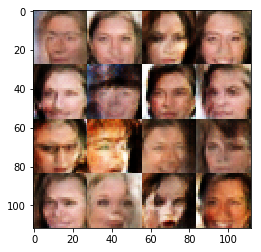

Epoch 1/1... Discriminator Loss: 1.2568... Generator Loss: 1.3365
Epoch 1/1... Discriminator Loss: 1.2342... Generator Loss: 1.0921
Epoch 1/1... Discriminator Loss: 1.2586... Generator Loss: 0.9508
Epoch 1/1... Discriminator Loss: 1.1781... Generator Loss: 0.9038
Epoch 1/1... Discriminator Loss: 1.6405... Generator Loss: 0.9018
Epoch 1/1... Discriminator Loss: 0.9797... Generator Loss: 0.8948
Epoch 1/1... Discriminator Loss: 1.0707... Generator Loss: 1.1464
Epoch 1/1... Discriminator Loss: 1.4290... Generator Loss: 1.2347
Epoch 1/1... Discriminator Loss: 1.0738... Generator Loss: 0.9129
Epoch 1/1... Discriminator Loss: 1.0537... Generator Loss: 0.9513


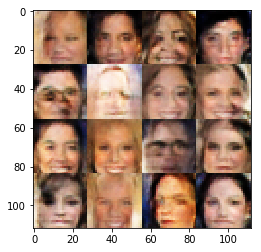

Epoch 1/1... Discriminator Loss: 0.9497... Generator Loss: 0.9607
Epoch 1/1... Discriminator Loss: 1.2508... Generator Loss: 0.8420
Epoch 1/1... Discriminator Loss: 1.3178... Generator Loss: 0.8177
Epoch 1/1... Discriminator Loss: 1.1966... Generator Loss: 1.1827
Epoch 1/1... Discriminator Loss: 1.0835... Generator Loss: 0.9095
Epoch 1/1... Discriminator Loss: 1.2491... Generator Loss: 1.0152
Epoch 1/1... Discriminator Loss: 1.2829... Generator Loss: 0.8502
Epoch 1/1... Discriminator Loss: 1.1379... Generator Loss: 0.7653
Epoch 1/1... Discriminator Loss: 1.1741... Generator Loss: 1.0400
Epoch 1/1... Discriminator Loss: 1.4872... Generator Loss: 0.5864


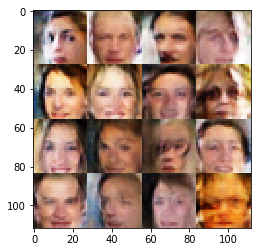

Epoch 1/1... Discriminator Loss: 1.1122... Generator Loss: 1.1008
Epoch 1/1... Discriminator Loss: 1.1563... Generator Loss: 0.7305
Epoch 1/1... Discriminator Loss: 1.3833... Generator Loss: 0.8664


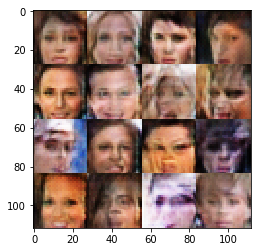

Done


In [19]:
batch_size = 32
z_dim = 100
learning_rate = 0.0005
beta1 = 0.4


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

## Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.